# Import packages

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Read in data

In [38]:
athletes = pd.read_csv("athletes.csv")
athletes.head()

athlete_id           name               region          team  \
0      2554.0      Pj Ablang           South West   Double Edge   
1      3517.0  Derek Abdella                  NaN           NaN   
2      4691.0            NaN                  NaN           NaN   
3      5164.0    Abo Brandon  Southern California  LAX CrossFit   
4      5286.0    Bryce Abbey                  NaN           NaN   

              affiliate gender   age  height  weight   fran  ...  snatch  \
0  Double Edge CrossFit   Male  24.0    70.0   166.0    NaN  ...     NaN   
1                   NaN   Male  42.0    70.0   190.0    NaN  ...     NaN   
2                   NaN    NaN   NaN     NaN     NaN    NaN  ...     NaN   
3          LAX CrossFit   Male  40.0    67.0     NaN  211.0  ...   200.0   
4                   NaN   Male  32.0    65.0   149.0  206.0  ...   150.0   

   deadlift  backsq  pullups  \
0     400.0   305.0      NaN   
1       NaN     NaN      NaN   
2       NaN     NaN      NaN   
3     375.0   325.0     25.0   
4       NaN   325.0     50.0   

                                                 eat  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3               I eat 1-3 full cheat meals per week|   
4  I eat quality foods but don't measure the amount|   

                                               train  \
0  I workout mostly at a CrossFit Affiliate|I hav...   
1  I have a coach who determines my programming|I...   
2                                                NaN   
3  I workout mostly at a CrossFit Affiliate|I hav...   
4  I workout mostly at a CrossFit Affiliate|I inc...   

                                          background  \
0  I played youth or high school level sports|I r...   
1        I played youth or high school level sports|   
2                                                NaN   
3        I played youth or high school level sports|   
4                           I played college sports|   

                                          experience  \
0  I began CrossFit with a coach (e.g. at an affi...   
1  I began CrossFit with a coach (e.g. at an affi...   
2                                                NaN   
3  I began CrossFit by trying it alone (without a...   
4  I began CrossFit by trying it alone (without a...   

                                            schedule     howlong  
0         I do multiple workouts in a day 2x a week|   4+ years|  
1         I do multiple workouts in a day 2x a week|   4+ years|  
2                                                NaN         NaN  
3                 I usually only do 1 workout a day|   4+ years|  
4  I usually only do 1 workout a day|I strictly s...  1-2 years|  

[5 rows x 27 columns]

In [39]:
# Get the relevant columns only
athletes_clean = athletes.loc[:, ["gender", "age", "height", "weight", "run5k", "deadlift", "eat", "train", "background", "experience", "schedule", "howlong"]].copy()

# Clean data

In [40]:
athletes_clean.describe()

age        height         weight         run5k      deadlift
count  331110.000000  1.598690e+05  229890.000000  3.609700e+04  1.153230e+05
mean       32.516750  1.206217e+02     170.896137  3.411464e+03  6.970503e+02
std         7.730671  2.097995e+04      58.379799  1.251980e+05  5.523235e+04
min        13.000000  0.000000e+00       1.000000  1.000000e+00 -5.000000e+02
25%        27.000000  6.600000e+01     145.000000  1.242000e+03  2.550000e+02
50%        31.000000  6.900000e+01     170.000000  1.380000e+03  3.450000e+02
75%        37.000000  7.200000e+01     192.000000  1.560000e+03  4.150000e+02
max       125.000000  8.388607e+06   20175.000000  8.388607e+06  8.388607e+06

Definitely some outliers in here. We will have to figure out what to do with those.

In [41]:
athletes.isna().sum()

athlete_id         3
name           91896
region        171744
team          267846
affiliate     181090
gender         91896
age            91896
height        263137
weight        193116
fran          367580
helen         392727
grace         382261
filthy50      403647
fgonebad      393268
run400        400760
run5k         386909
candj         318571
snatch        325726
deadlift      307683
backsq        312489
pullups       372398
eat           329074
train         317175
background    324061
experience    318070
schedule      325131
howlong       313800
dtype: int64

PLENTY of missing values here. Our dataset will be considerably smaller by the time we actually go to model.

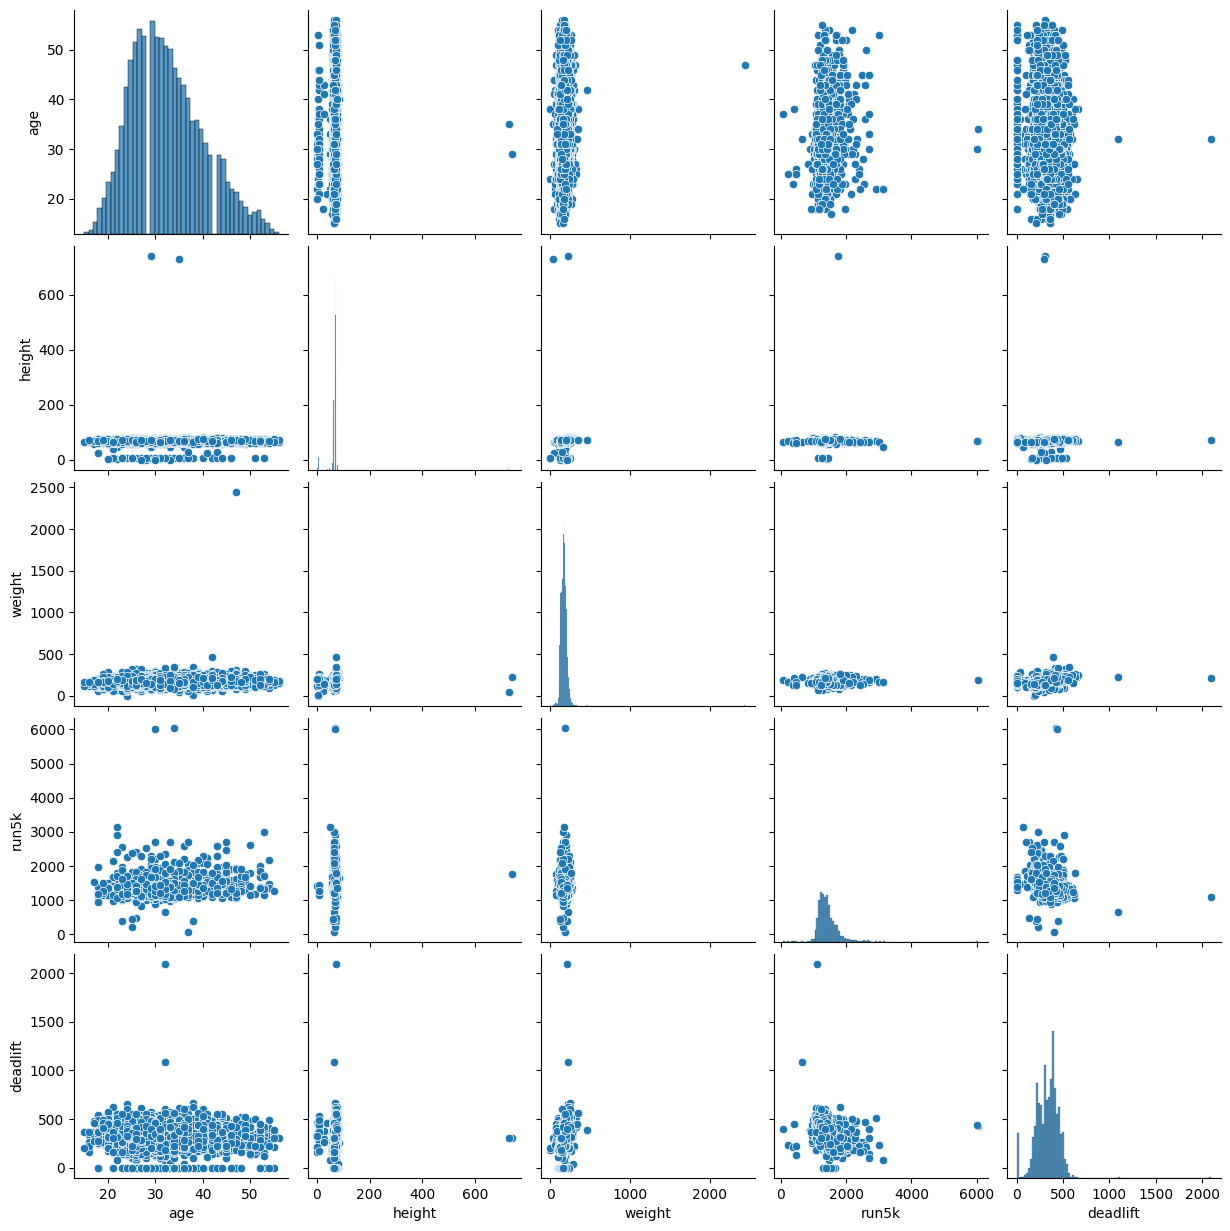

In [42]:
athletes_sampled = athletes_clean.sample(n = 12000, random_state = 31958)
sns.pairplot(athletes_sampled);

Despite some outliers and some wierd looking gaps in age, this looks pretty normally distributed and solid overall.

In [43]:
# Start by removing weird values from the above plot.
athletes_clean = athletes_clean.query('weight >= 100 and weight <= 320 and \
                                      height >= 54 and height <= 85 and \
                                      age <= 85 and \
                                      run5k >= 755 and run5k <= 2700 and \
                                      deadlift >= 45 and deadlift <= 1185')

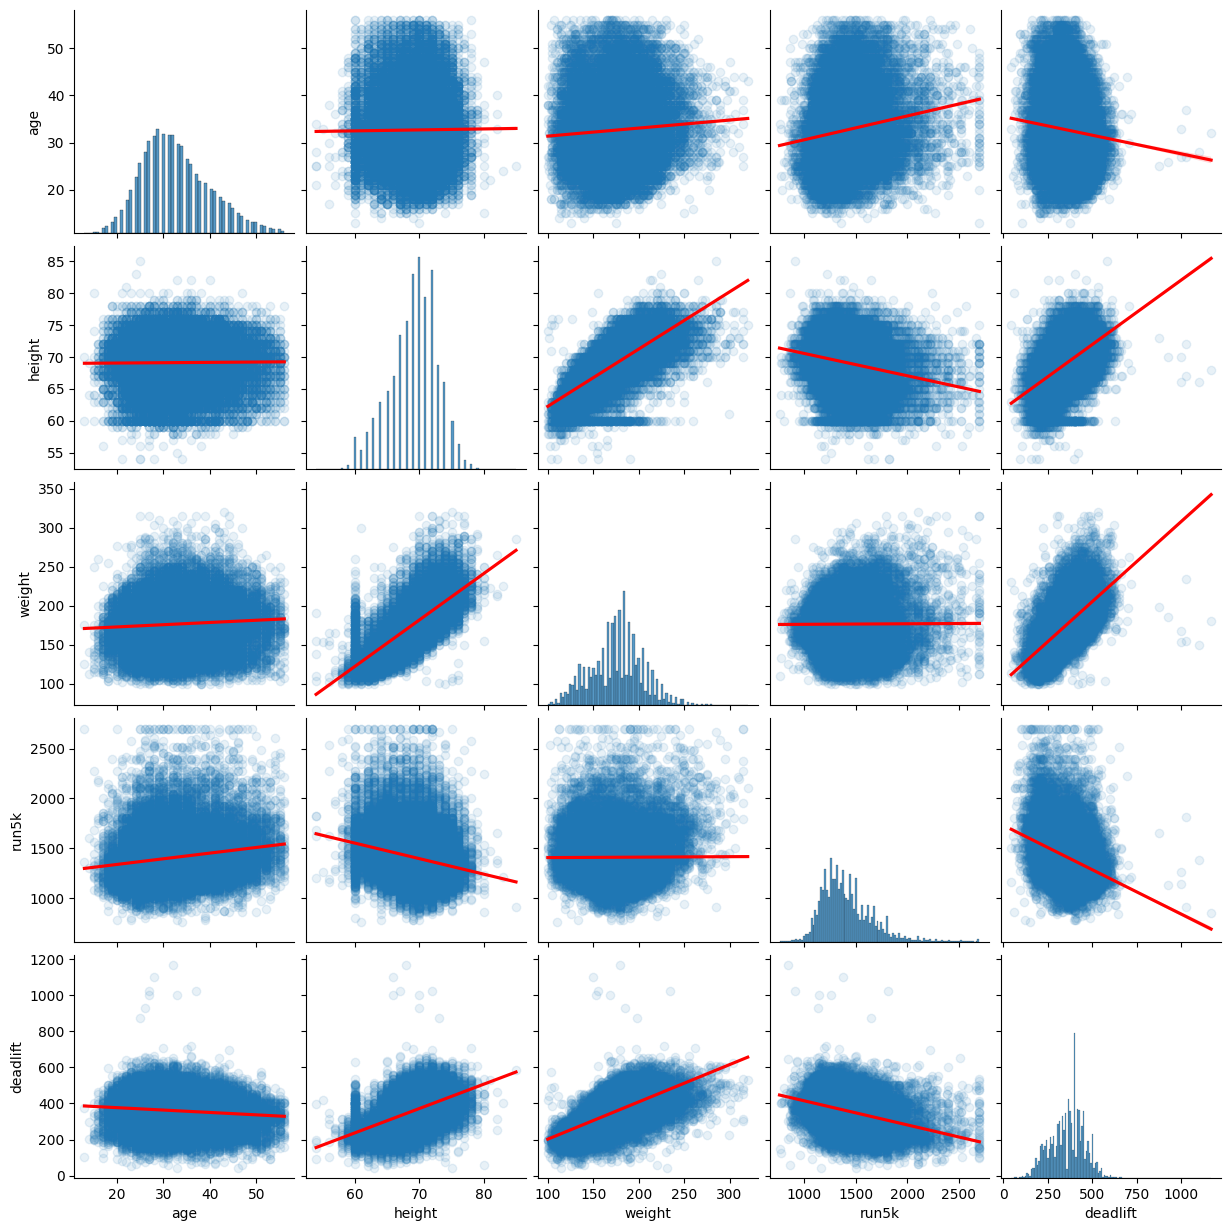

In [44]:
sns.pairplot(athletes_clean, kind = 'reg', plot_kws = {'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.1}});

Some relationships look considerably less significant now, but let's continue on to the non-numeric data.
<br>
<br>
Much of the categorical data has multiple answer selected per athlete, so we will need to find a way around this.

In [45]:
athletes_clean.head()

gender   age  height  weight   run5k  deadlift  \
9    Male  40.0    68.0   177.0  1361.0     365.0   
12   Male  31.0    65.0   150.0  1211.0     465.0   
18   Male  30.0    70.0   155.0  1140.0     335.0   
20   Male  42.0    72.0   210.0  1412.0     515.0   
21   Male  30.0    71.0   200.0  1584.0     385.0   

                                                  eat  \
9   I eat quality foods but don't measure the amount|   
12  I eat quality foods but don't measure the amou...   
18                                                NaN   
20  I eat quality foods but don't measure the amount|   
21                      I eat whatever is convenient|   

                                                train  \
9   I workout mostly at a CrossFit Affiliate|I rec...   
12  I workout mostly at a CrossFit Affiliate|I wri...   
18                                                NaN   
20  I workout mostly at a CrossFit Affiliate|I wri...   
21  I workout mostly at a CrossFit Affiliate|I inc...   

                                           background  \
9   I played youth or high school level sports|I p...   
12  I played youth or high school level sports|I p...   
18                                                NaN   
20        I played youth or high school level sports|   
21  I played youth or high school level sports|I p...   

                                           experience  \
9   I began CrossFit by trying it alone (without a...   
12  I began CrossFit by trying it alone (without a...   
18                                                NaN   
20  I began CrossFit with a coach (e.g. at an affi...   
21  I began CrossFit by trying it alone (without a...   

                                             schedule     howlong  
9   I usually only do 1 workout a day|I typically ...  2-4 years|  
12   I do multiple workouts in a day 3+ times a week|  2-4 years|  
18                                                NaN         NaN  
20                                                NaN   4+ years|  
21  I do multiple workouts in a day 1x a week|I ty...  1-2 years|

##### Gender

In [46]:
dummy_gender = pd.get_dummies(athletes_clean['gender']).drop('--', axis = 1)
athletes_clean = pd.concat([athletes_clean, dummy_gender], axis = 1)

##### Eating habits

In [47]:
# Drop rows with NaN in 'eat' column
athletes_clean = athletes_clean.dropna(subset = ['eat'])

# Split the values in the 'eat' column by "|" and create dummy variables
dummy_eats = pd.get_dummies(athletes_clean['eat'].str.split('|', expand = True).stack(), prefix = 'eat').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_eats = dummy_eats.drop(columns = 'eat_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_eats], axis=1)

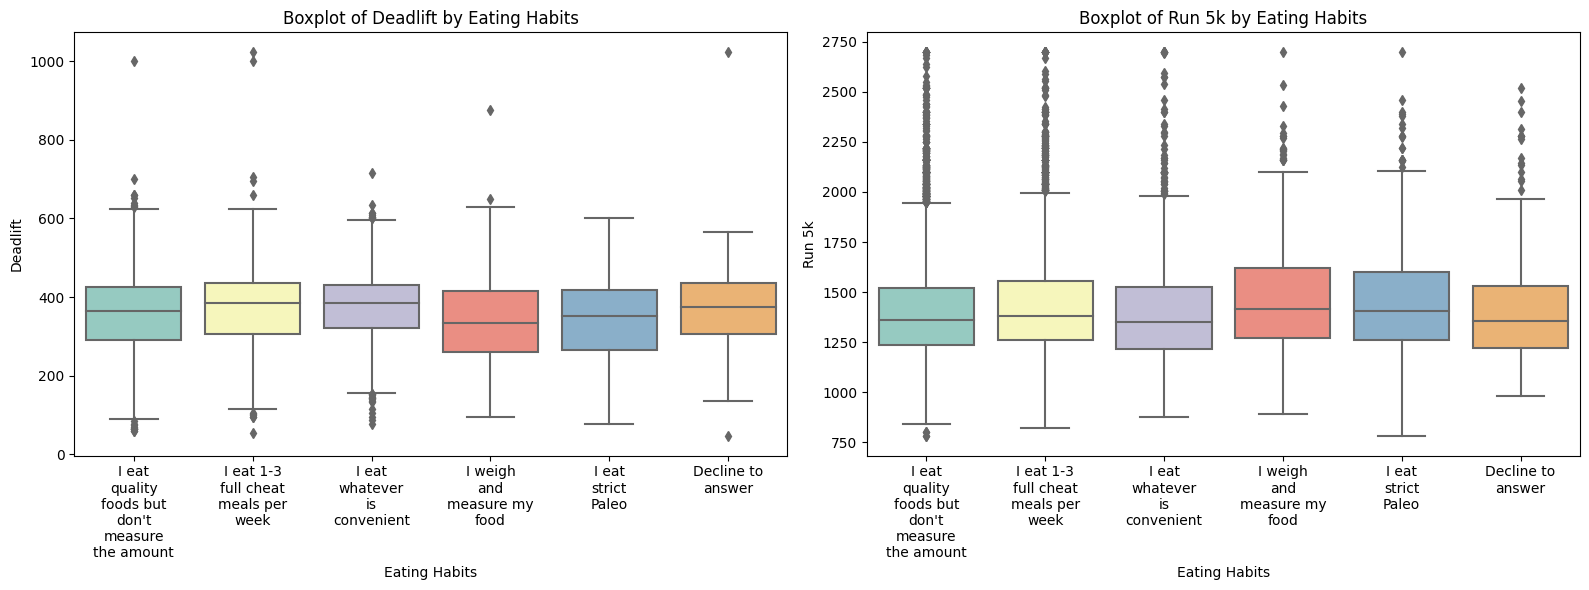

In [48]:
import textwrap

# Create a new column 'eating_habits' combining all eating habits for each athlete
athletes_clean['eating_habits'] = athletes_clean.filter(like='eat_').idxmax(axis=1).str.replace('eat_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['eating_habits'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x='eating_habits', y='deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Eating Habits')
axes[0].set_xlabel('Eating Habits')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='eating_habits', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Eating Habits')
axes[1].set_xlabel('Eating Habits')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

It doesn't look like the groups are that different, although they do overlap some anyway, which may provide some of the reason for that.

##### Training

In [49]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset=['train'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_train = pd.get_dummies(athletes_clean['train'].str.split('|', expand = True).stack(), prefix = 'train').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_train = dummy_train.drop(columns = 'train_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_train], axis=1)

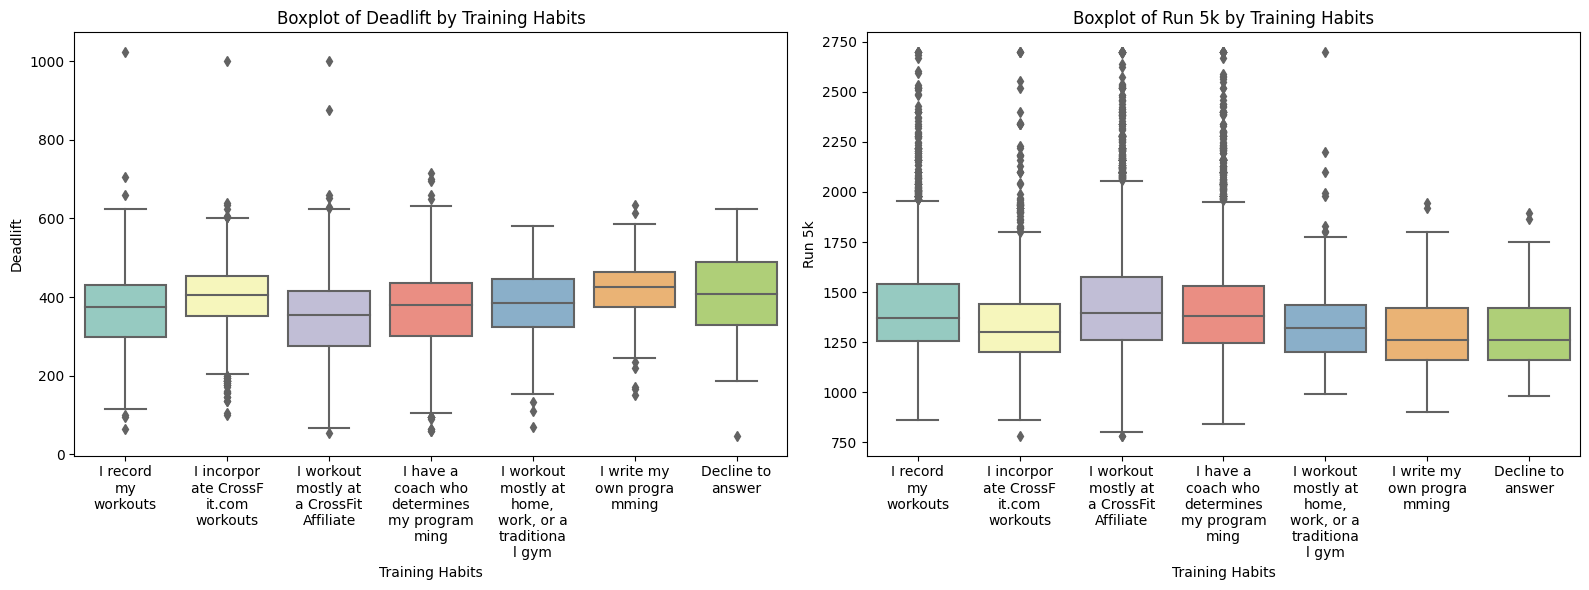

In [50]:
# Create a new column 'training_habits' combining all training habits for each athlete
athletes_clean['training_habits'] = athletes_clean.filter(like = 'train_').idxmax(axis=1).str.replace('train_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_habits'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x='training_habits', y='deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Training Habits')
axes[0].set_xlabel('Training Habits')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_habits', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Training Habits')
axes[1].set_xlabel('Training Habits')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Athletic background

In [51]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['background'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_background = pd.get_dummies(athletes_clean['background'].str.split('|', expand = True).stack(), prefix = 'background').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_background = dummy_background.drop(columns = 'background_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_background], axis = 1)

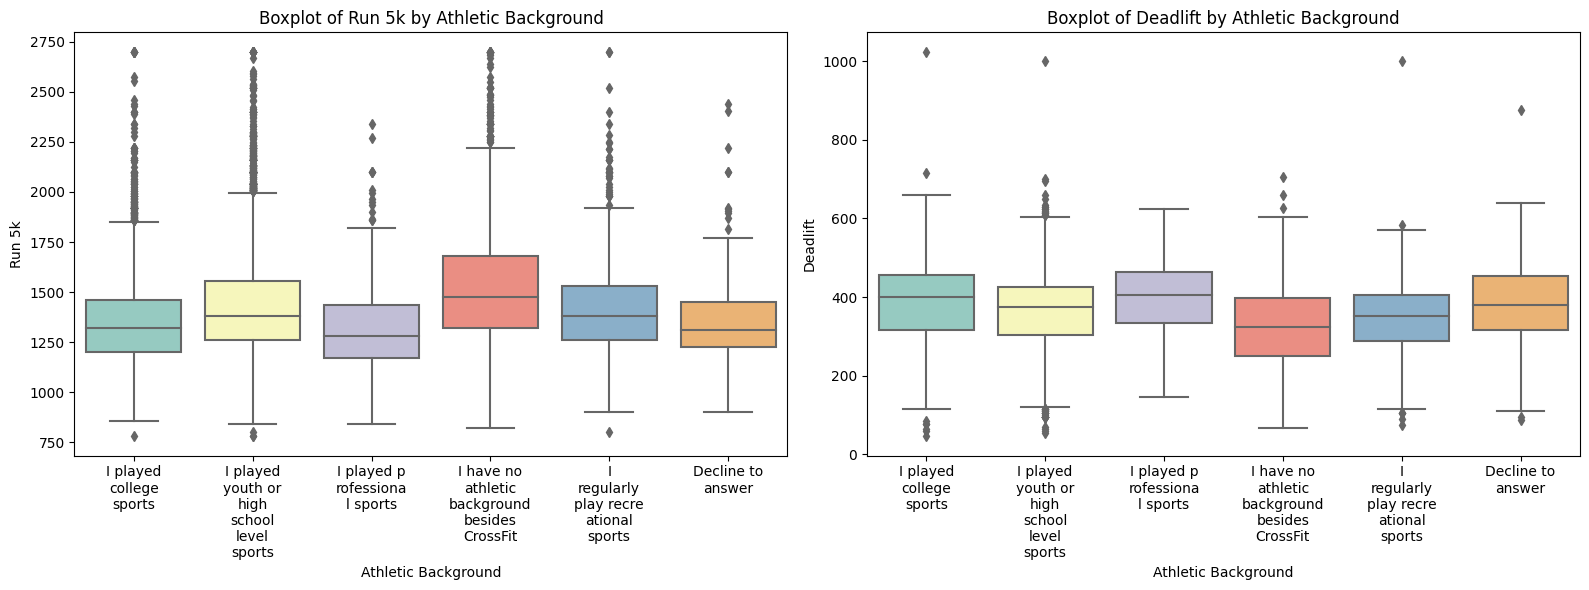

In [52]:
# Create a new column 'training_habits' combining all training habits for each athlete
athletes_clean['athletic_bg'] = athletes_clean.filter(like = 'background_').idxmax(axis=1).str.replace('background_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['athletic_bg'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[0], x='athletic_bg', y='run5k', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Run 5k by Athletic Background')
axes[0].set_xlabel('Athletic Background')
axes[0].set_ylabel('Run 5k')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[1], x='athletic_bg', y='deadlift', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Deadlift by Athletic Background')
axes[1].set_xlabel('Athletic Background')
axes[1].set_ylabel('Deadlift')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Crossfit experience

In [53]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['experience'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_experience = pd.get_dummies(athletes_clean['experience'].str.split('|', expand = True).stack(), prefix = 'experience').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_experience = dummy_experience.drop(columns = 'experience_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_experience], axis = 1)

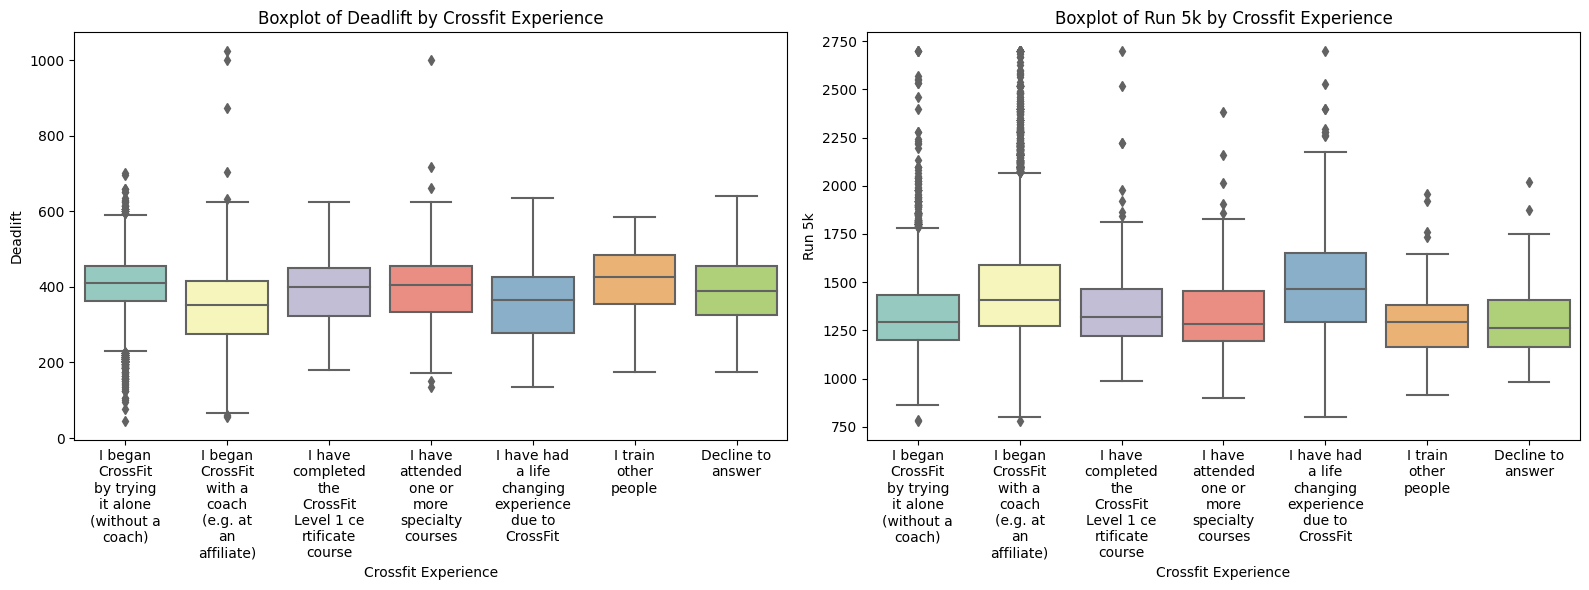

In [54]:
# Create a new column 'crossfit_experience' combining all training habits for each athlete
athletes_clean['crossfit_experience'] = athletes_clean.filter(like = 'experience_').idxmax(axis=1).str.replace('experience_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['crossfit_experience'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x = 'crossfit_experience', y = 'deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Crossfit Experience')
axes[0].set_xlabel('Crossfit Experience')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='crossfit_experience', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Crossfit Experience')
axes[1].set_xlabel('Crossfit Experience')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Training schedule

In [55]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['schedule'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_schedule = pd.get_dummies(athletes_clean['schedule'].str.split('|', expand = True).stack(), prefix = 'schedule').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_schedule = dummy_schedule.drop(columns = 'schedule_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_schedule], axis = 1)

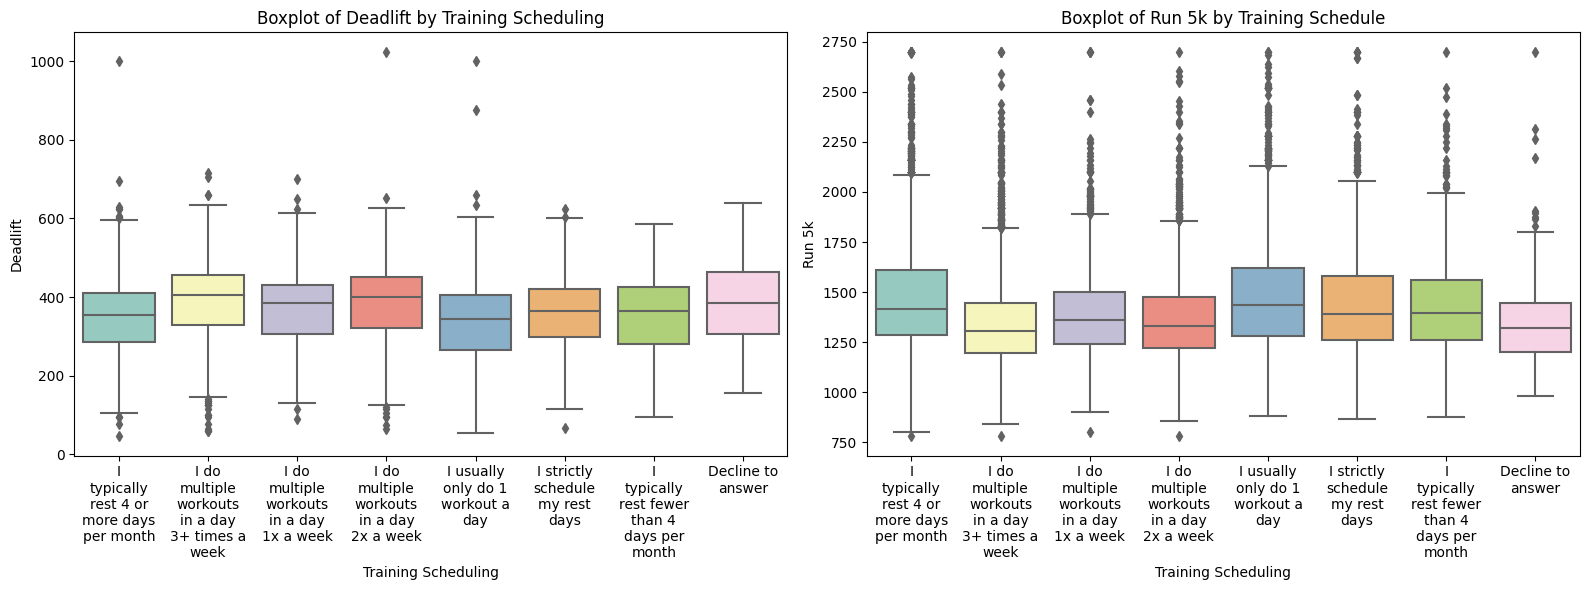

In [56]:
# Create a new column 'training_schedule' combining all training schedules for each athlete
athletes_clean['training_schedule'] = athletes_clean.filter(like = 'schedule_').idxmax(axis=1).str.replace('schedule_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_schedule'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax = axes[0], x = 'training_schedule', y = 'deadlift', data = athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Training Scheduling')
axes[0].set_xlabel('Training Scheduling')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_schedule', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Training Schedule')
axes[1].set_xlabel('Training Scheduling')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### How long have they been training

In [57]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['howlong'])

def find_longest_training(row):
    if pd.isna(row):
        return np.nan

    weights = {'Less than 6 months': 1, '6-12 months': 2, '1-2 years': 3, '2-4 years': 4, '4+ years': 5}

    categories = row.split('|')
    return max(categories, key = lambda x: weights.get(x, 0))

# Create a new column 'howlong_group' based on the longest category
athletes_clean['howlong_group'] = athletes_clean['howlong'].apply(find_longest_training)

# Split the values in the 'train' column by "|" and create dummy variables
dummy_howlong = pd.get_dummies(athletes_clean['howlong_group'].str.split('|', expand = True).stack(), prefix = 'howlong').groupby(level = 0).sum()

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_howlong], axis = 1)

<ipython-input-57-e235ea598182>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  athletes_clean['howlong_group'] = athletes_clean['howlong'].apply(find_longest_training)


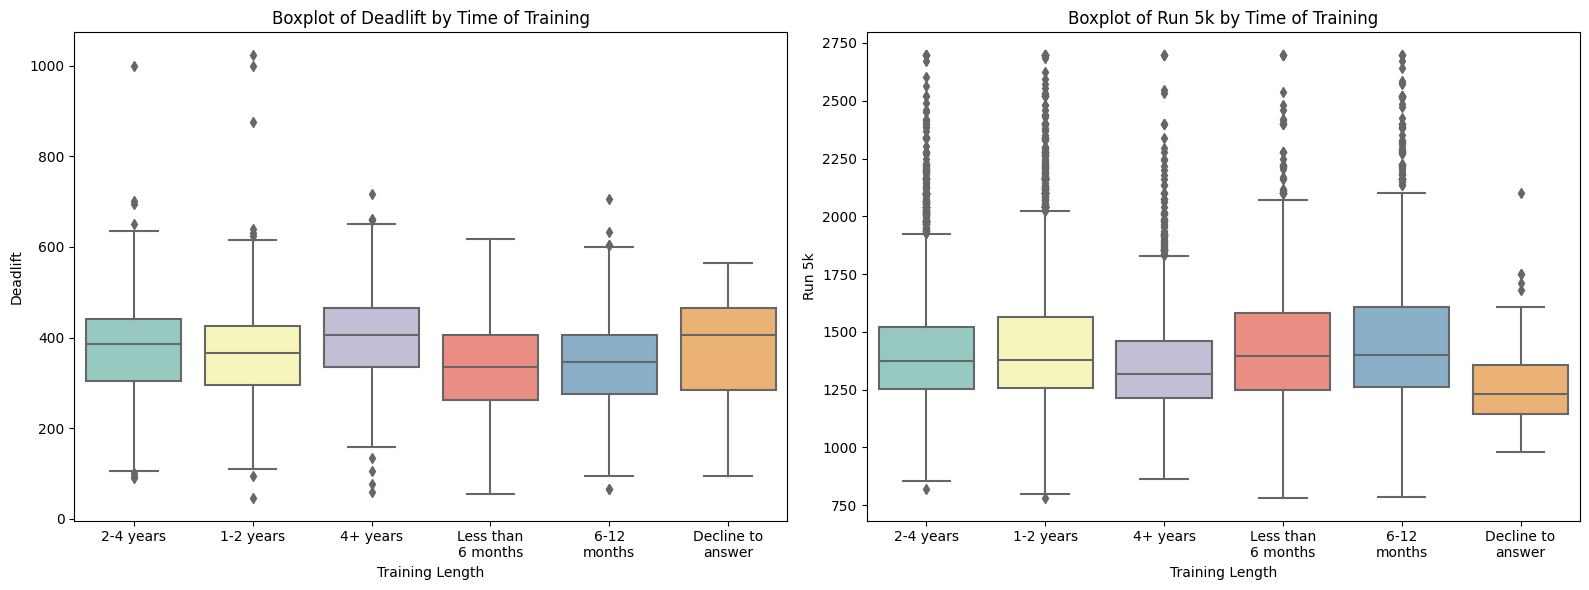

In [58]:
# Create a new column 'training_schedule' combining all training schedules for each athlete
athletes_clean['training_length'] = athletes_clean.filter(like = 'howlong_').drop('howlong_group', axis = 1).idxmax(axis=1).str.replace('howlong_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_length'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax = axes[0], x = 'training_length', y = 'deadlift', data = athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Time of Training')
axes[0].set_xlabel('Training Length')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_length', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Time of Training')
axes[1].set_xlabel('Training Length')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

# Model

#### Deadlift

In [59]:
athletes_clean['age_squared'] = athletes_clean['age']**2
deadlift_nuts = athletes_clean.sample(n = 2000)
# Make predictors for model
deadlift_x = deadlift_nuts.loc[:, ['age', 'age_squared', 'height', 'weight', 'Female', 'Male', 'eat_Decline to answer', 'eat_I eat 1-3 full cheat meals per week',
                                    "eat_I eat quality foods but don't measure the amount", 'eat_I eat strict Paleo', 'eat_I eat whatever is convenient',
                                    'eat_I weigh and measure my food', 'train_Decline to answer', 'train_I have a coach who determines my programming',
                                    'train_I incorporate CrossFit.com workouts', 'train_I record my workouts', 'train_I workout mostly at a CrossFit Affiliate',
                                    'train_I workout mostly at home, work, or a traditional gym', 'train_I write my own programming',
                                    'background_Decline to answer', 'background_I have no athletic background besides CrossFit', 'background_I played college sports',
                                    'background_I played professional sports', 'background_I played youth or high school level sports',
                                    'background_I regularly play recreational sports', 'experience_I began CrossFit by trying it alone (without a coach)',
                                    'experience_I began CrossFit with a coach (e.g. at an affiliate)', 'experience_I have attended one or more specialty courses',
                                    'experience_I have completed the CrossFit Level 1 certificate course', 'experience_I have had a life changing experience due to CrossFit',
                                    'experience_I train other people', 'schedule_Decline to answer',
                                    'schedule_I do multiple workouts in a day 1x a week',
                                    'schedule_I do multiple workouts in a day 2x a week',
                                    'schedule_I do multiple workouts in a day 3+ times a week',
                                    'schedule_I strictly schedule my rest days',
                                    'schedule_I typically rest 4 or more days per month',
                                    'schedule_I typically rest fewer than 4 days per month',
                                    'schedule_I usually only do 1 workout a day',
                                    'howlong_1-2 years',
                                    'howlong_2-4 years', 'howlong_4+ years', 'howlong_6-12 months',
                                    'howlong_Decline to answer', 'howlong_Less than 6 months']].apply(pd.to_numeric, errors='coerce')

# Make response variable for model
deadlift_y = deadlift_nuts.deadlift.to_numpy()

In [60]:
k = deadlift_x.shape[1]

with pm.Model() as deadlift_model:
    # Priors for coefficients
    beta = pm.Normal('beta', mu = 0, sigma = 10, shape = k)
    sigma = pm.HalfNormal('sigma', sigma = 10)

    # Intercept
    alpha = pm.Normal('alpha', mu = 0, sigma = 10)

    # Linear regression model
    mu = pm.Deterministic('mu', alpha + pm.math.dot(deadlift_x, beta))

    # Likelihood
    y = pm.Normal('y', mu = mu, sigma = sigma, observed = deadlift_y)

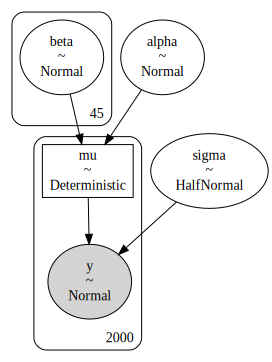

In [61]:
# Graphical representation
pm.model_to_graphviz(deadlift_model)

In [62]:
with deadlift_model:
    deadlift_trace = pm.sample(2000, tune = 1000, random_seed = 31958)

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (46), generating only 20 plots
  warnings.warn(


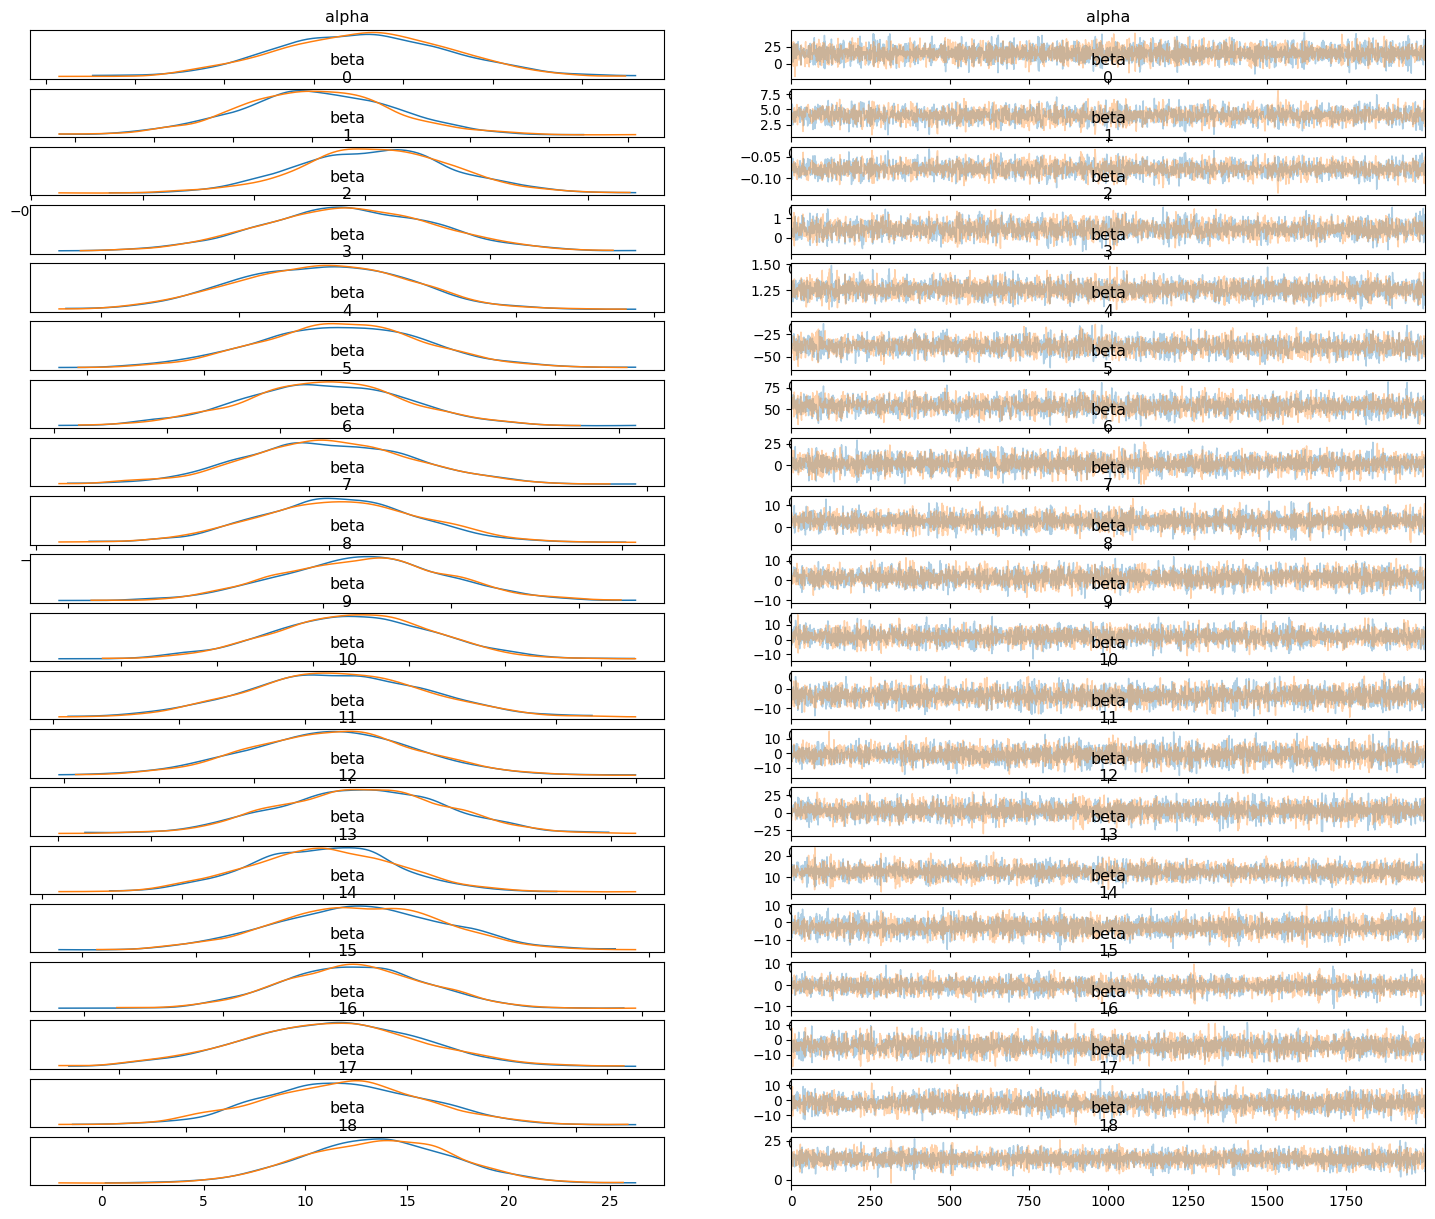

In [63]:
az.plot_trace(deadlift_trace, compact = False, var_names = ['alpha', 'beta'], figsize = (18, 15));

In [64]:
az.summary(deadlift_trace, var_names = ['alpha', 'beta'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     15.606  9.578  -2.468   33.152      0.107    0.091    8082.0   
beta[0]    4.025  0.979   2.077    5.791      0.018    0.013    2973.0   
beta[1]   -0.078  0.014  -0.106   -0.053      0.000    0.000    2959.0   
beta[2]    0.450  0.341  -0.170    1.117      0.006    0.004    3654.0   
beta[3]    1.260  0.062   1.143    1.371      0.001    0.001    6366.0   
beta[4]  -38.209  7.186 -52.239  -24.951      0.118    0.084    3685.0   
beta[5]   53.904  7.289  40.478   68.252      0.118    0.084    3826.0   
beta[6]    1.717  7.508 -12.207   16.175      0.093    0.122    6556.0   
beta[7]    2.842  2.763  -2.175    8.109      0.031    0.032    7864.0   
beta[8]    1.570  3.247  -4.675    7.367      0.046    0.041    5056.0   
beta[9]    2.086  4.137  -5.481   10.087      0.052    0.057    6363.0   
beta[10]  -3.720  3.489  -9.987    2.939      0.043    0.038    6577.0   
beta[11]  -0.940  4.450  -9.166    7.563      0.058    0.072    5969.0   
beta[12]   2.805  9.138 -13.727   19.779      0.103    0.144    7851.0   
beta[13]  12.475  2.615   7.559   17.401      0.029    0.021    8229.0   
beta[14]  -2.761  3.733  -9.822    3.953      0.042    0.052    8086.0   
beta[15]  -0.337  2.566  -5.282    4.215      0.029    0.044    7783.0   
beta[16]  -4.162  4.529 -12.275    4.848      0.056    0.057    6438.0   
beta[17]  -1.966  4.175  -9.408    6.167      0.054    0.059    5921.0   
beta[18]  13.532  3.654   6.915   20.507      0.041    0.031    7867.0   
beta[19]  13.658  8.474  -3.664   28.002      0.097    0.086    7604.0   
beta[20] -11.048  4.197 -18.976   -3.418      0.059    0.043    5049.0   
beta[21]   8.904  2.775   3.519   14.055      0.034    0.025    6681.0   
beta[22]   7.689  5.883  -3.361   18.521      0.062    0.064    9091.0   
beta[23]   0.448  3.191  -5.718    6.209      0.043    0.049    5460.0   
beta[24]  -2.390  2.640  -7.070    2.883      0.026    0.034   10249.0   
beta[25]   8.032  4.754  -1.138   16.602      0.069    0.050    4745.0   
beta[26]  -5.257  4.595 -14.219    3.139      0.068    0.055    4578.0   
beta[27]   3.096  3.508  -3.308    9.966      0.041    0.045    7142.0   
beta[28]  12.513  3.784   5.436   19.710      0.048    0.034    6173.0   
beta[29]  -5.268  2.634 -10.251   -0.343      0.032    0.027    6831.0   
beta[30]   6.474  3.886  -0.751   14.013      0.050    0.043    6021.0   
beta[31]  -2.009  8.185 -17.704   13.391      0.092    0.139    7863.0   
beta[32]   4.084  4.023  -3.572   11.297      0.053    0.057    5704.0   
beta[33]   9.946  3.759   3.069   17.064      0.055    0.041    4751.0   
beta[34]  16.539  3.757   9.340   23.213      0.059    0.042    4018.0   
beta[35]   4.195  3.147  -2.003    9.646      0.033    0.035    9215.0   
beta[36]   1.389  2.577  -3.556    6.011      0.029    0.037    7902.0   
beta[37]   6.675  3.892  -0.577   13.895      0.044    0.038    7800.0   
beta[38]  -5.808  3.223 -11.946    0.366      0.053    0.037    3740.0   
beta[39]   4.613  4.769  -4.097   13.868      0.092    0.065    2703.0   
beta[40]  17.643  4.877   8.489   27.036      0.093    0.066    2741.0   
beta[41]  24.618  5.368  14.988   35.034      0.099    0.070    2944.0   
beta[42] -13.566  5.137 -23.564   -4.335      0.095    0.068    2924.0   
beta[43]   8.144  9.227  -9.789   24.706      0.092    0.124   10006.0   
beta[44] -26.334  5.753 -37.339  -15.858      0.094    0.067    3745.0   

          ess_tail  r_hat  
alpha       2975.0    1.0  
beta[0]     2498.0    1.0  
beta[1]     2753.0    1.0  
beta[2]     3075.0    1.0  
beta[3]     3152.0    1.0  
beta[4]     2778.0    1.0  
beta[5]     2977.0    1.0  
beta[6]     2878.0    1.0  
beta[7]     2674.0    1.0  
beta[8]     3370.0    1.0  
beta[9]     2851.0    1.0  
beta[10]    3503.0    1.0  
beta[11]    2278.0    1.0  
beta[12]    3255.0    1.0  
beta[13]    2925.0    1.0  
beta[14]    2916.0    1.0  
beta[15]    3164.0    1.0  
beta[16]    2874.0    1.0  
b

The rhats and the trace plots show a well-converged model!

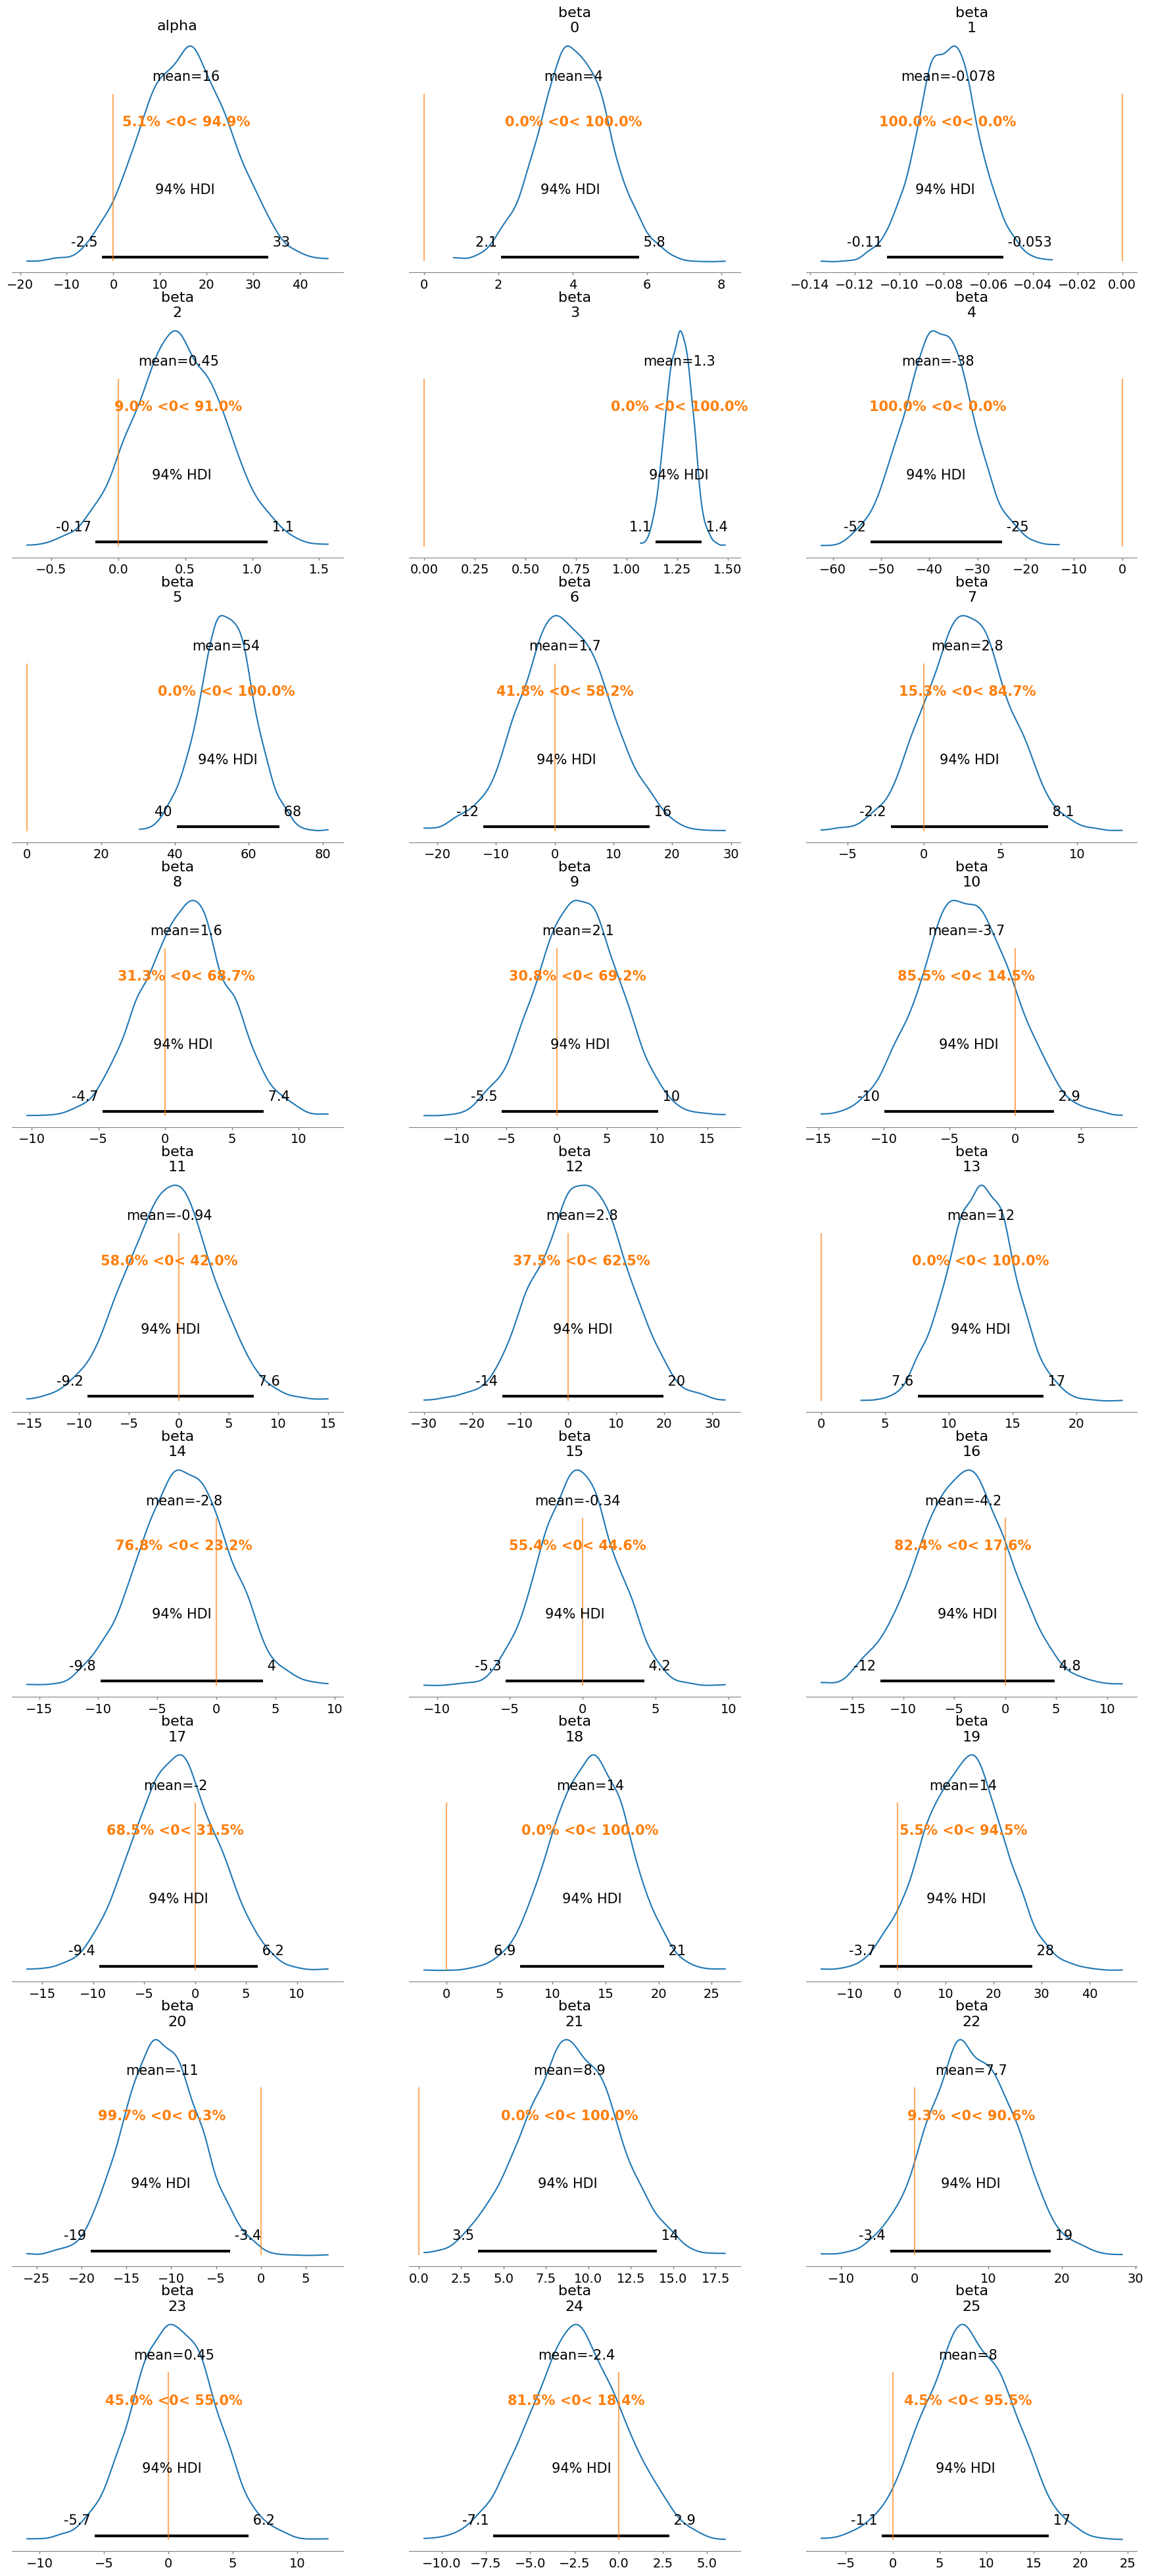

In [65]:
az.plot_posterior(
    deadlift_trace,
    var_names=['alpha', 'beta'],
    ref_val=0,
    coords={'beta_dim_0': slice(0, 25)}
);

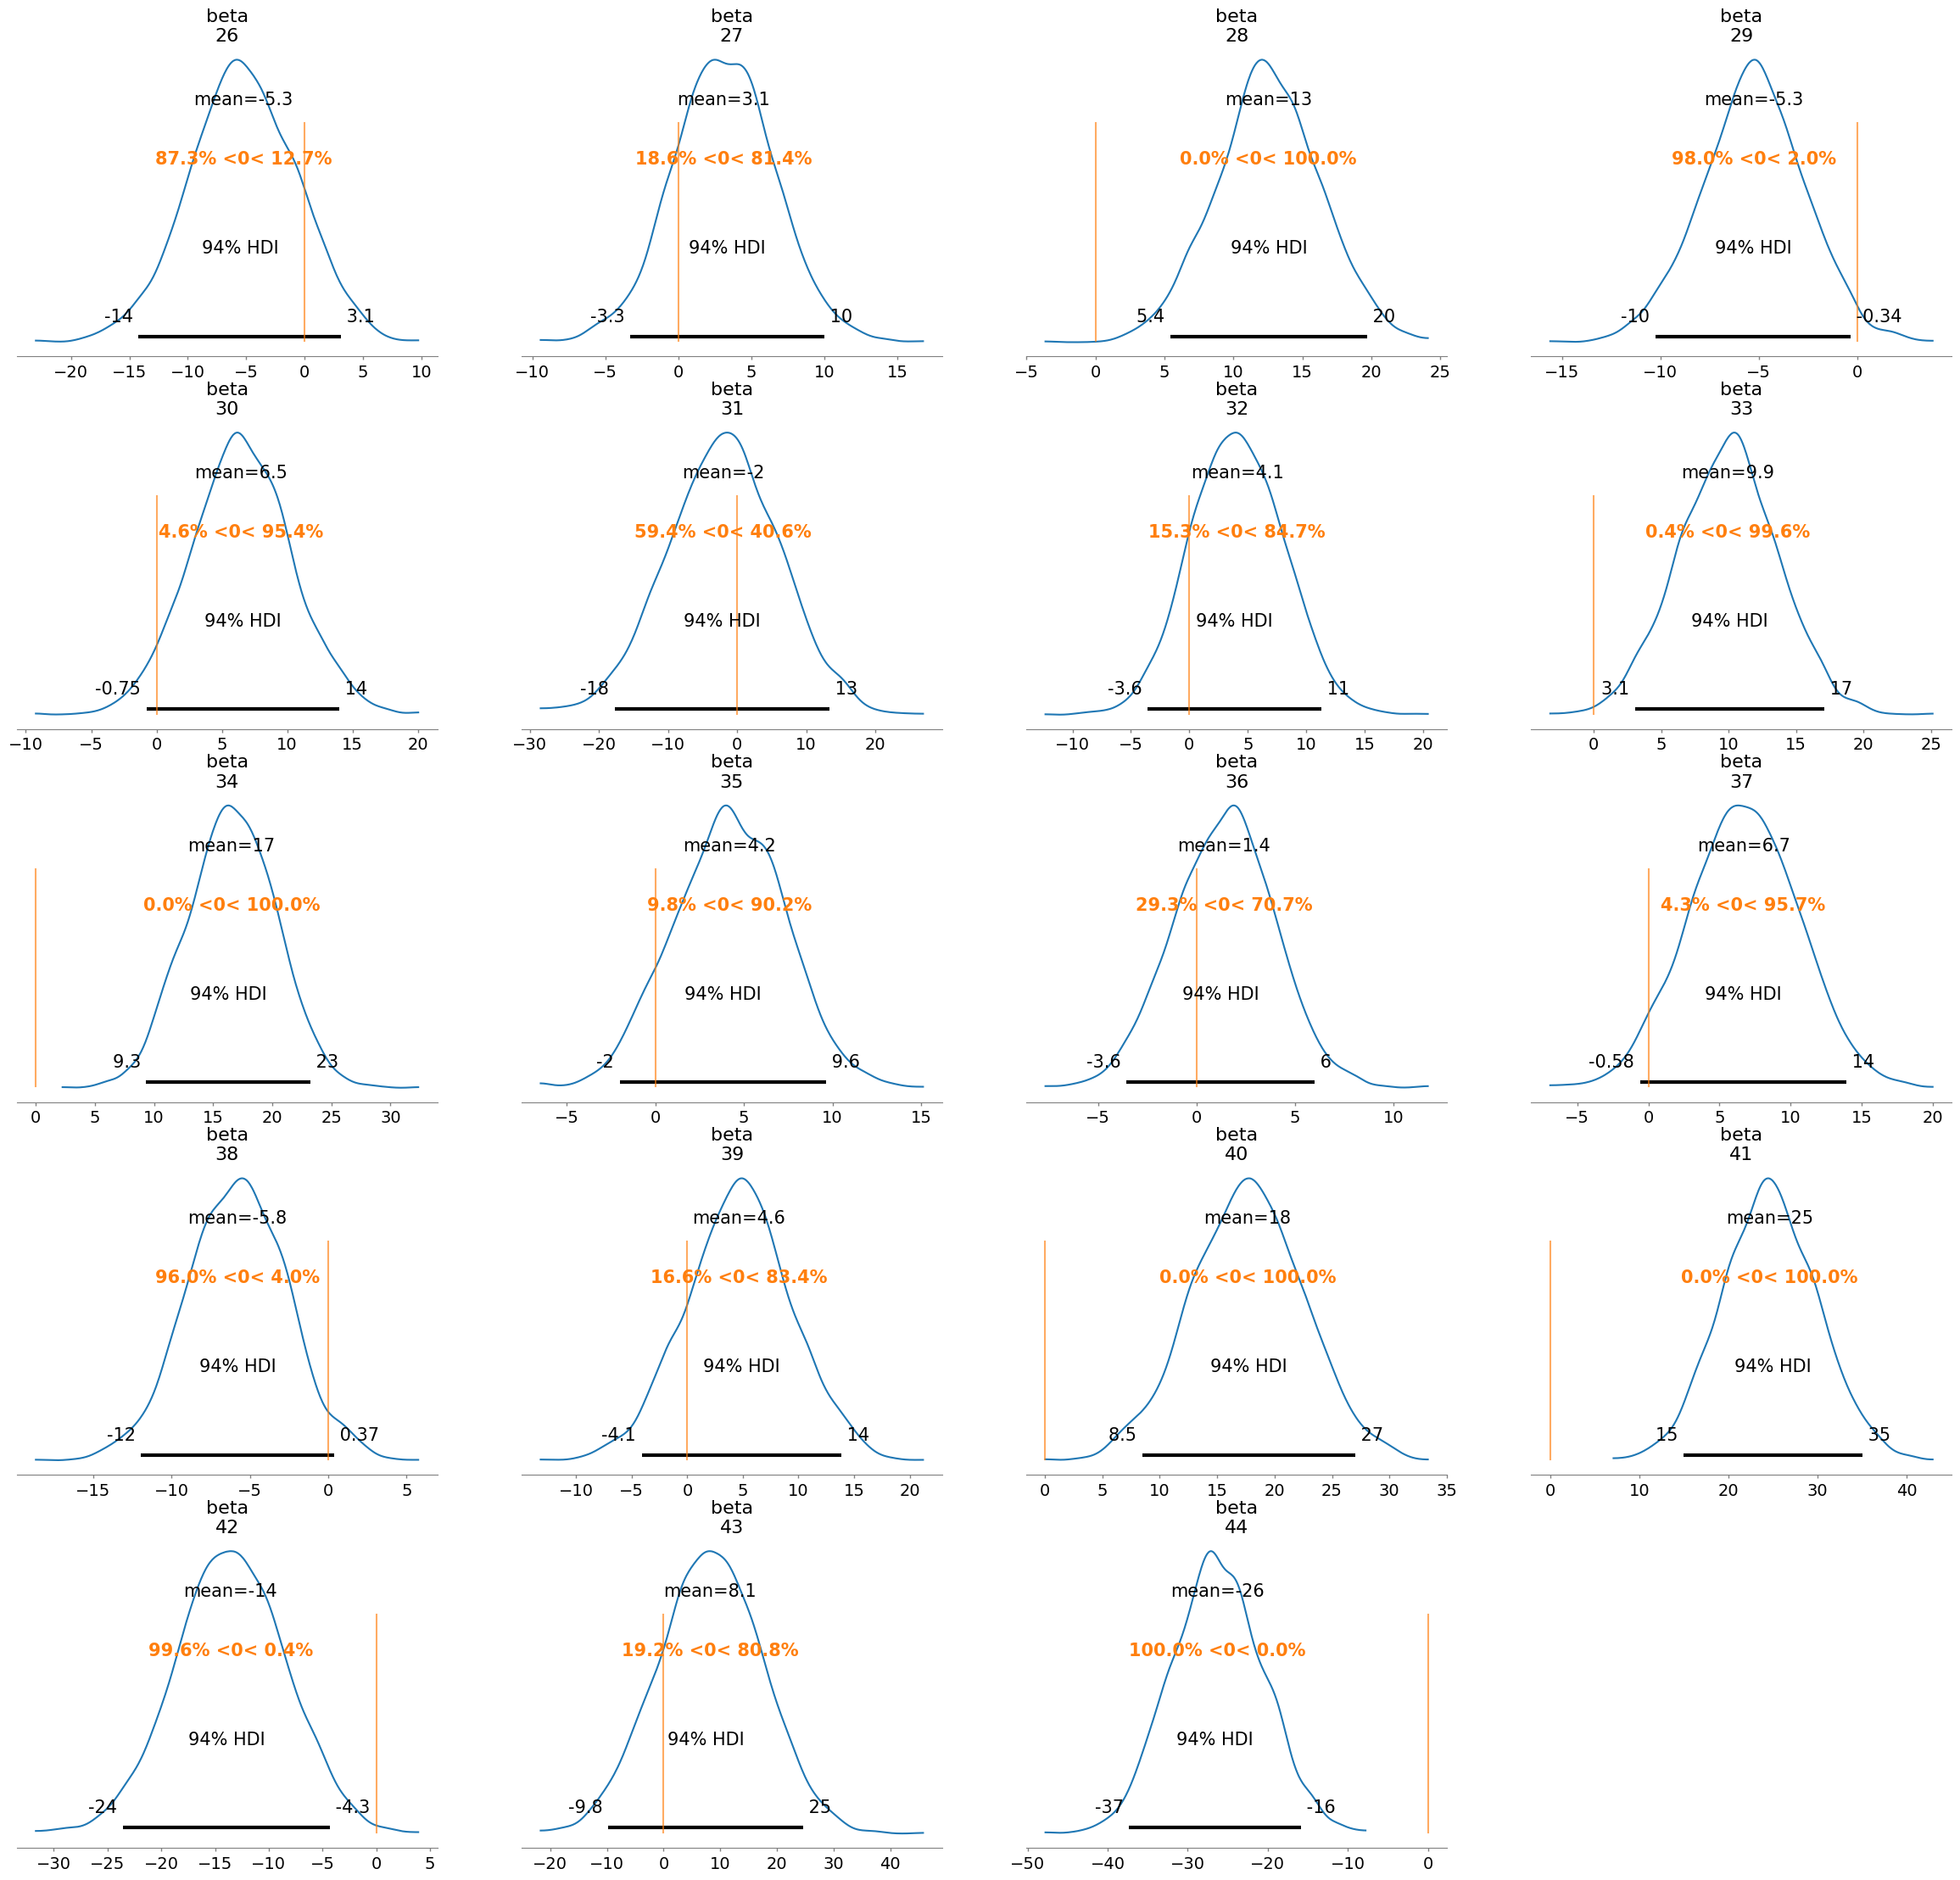

In [66]:
az.plot_posterior(
    deadlift_trace,
    var_names = ['beta'],
    ref_val = 0,
    coords = {'beta_dim_0': slice(26, 45)}
);

In [ ]:
deadlift_pp = pm.sample_posterior_predictive(
    deadlift_trace,
    model = deadlift_model
)

az.plot_bpv(deadlift_pp)

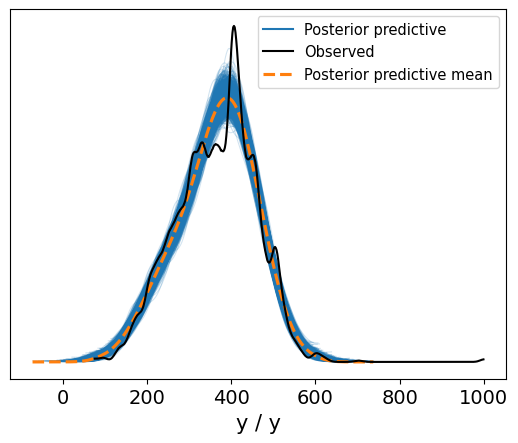

In [67]:
az.plot_ppc(deadlift_pp);

#### 5k Time

In [68]:
run_nuts = athletes_clean.sample(n = 2000)
# Make predictors for model
run_x = run_nuts.loc[:, ['age', 'age_squared', 'height', 'weight', 'Female', 'Male', 'eat_Decline to answer', 'eat_I eat 1-3 full cheat meals per week',
                              "eat_I eat quality foods but don't measure the amount", 'eat_I eat strict Paleo', 'eat_I eat whatever is convenient',
                              'eat_I weigh and measure my food', 'train_Decline to answer', 'train_I have a coach who determines my programming',
                              'train_I incorporate CrossFit.com workouts', 'train_I record my workouts', 'train_I workout mostly at a CrossFit Affiliate',
                              'train_I workout mostly at home, work, or a traditional gym', 'train_I write my own programming',
                              'background_Decline to answer', 'background_I have no athletic background besides CrossFit', 'background_I played college sports',
                              'background_I played professional sports', 'background_I played youth or high school level sports',
                              'background_I regularly play recreational sports', 'experience_I began CrossFit by trying it alone (without a coach)',
                              'experience_I began CrossFit with a coach (e.g. at an affiliate)', 'experience_I have attended one or more specialty courses',
                              'experience_I have completed the CrossFit Level 1 certificate course', 'experience_I have had a life changing experience due to CrossFit',
                              'experience_I train other people', 'schedule_Decline to answer',
                              'schedule_I do multiple workouts in a day 1x a week',
                              'schedule_I do multiple workouts in a day 2x a week',
                              'schedule_I do multiple workouts in a day 3+ times a week',
                              'schedule_I strictly schedule my rest days',
                              'schedule_I typically rest 4 or more days per month',
                              'schedule_I typically rest fewer than 4 days per month',
                              'schedule_I usually only do 1 workout a day',
                              'howlong_1-2 years',
                              'howlong_2-4 years', 'howlong_4+ years', 'howlong_6-12 months',
                              'howlong_Decline to answer', 'howlong_Less than 6 months']].apply(pd.to_numeric, errors='coerce')

# Make response variable for model
run_y = run_nuts.run5k.to_numpy()

In [69]:
k = run_x.shape[1]

with pm.Model() as run_model:
    # Priors for coefficients
    beta = pm.Normal('beta', mu = 0, sigma = 100, shape = k)
    sigma = pm.HalfNormal('sigma', sigma = 100)

    # Intercept
    alpha = pm.Normal('alpha', mu = 0, sigma = 50)

    # Linear regression model
    mu = pm.Deterministic('mu', alpha + pm.math.dot(run_x, beta))

    # Likelihood
    y = pm.SkewNormal('y', alpha = 6, mu = mu, sigma = sigma, observed = run_y)

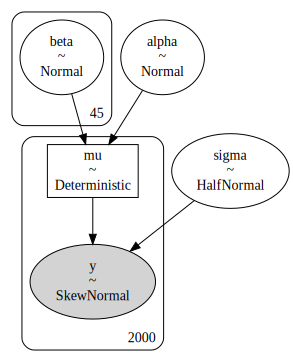

In [70]:
# Graphical representation
pm.model_to_graphviz(run_model)

In [71]:
with run_model:
    run_trace = pm.sample(2000, tune = 1000, random_seed = 31958)

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (46), generating only 20 plots
  warnings.warn(


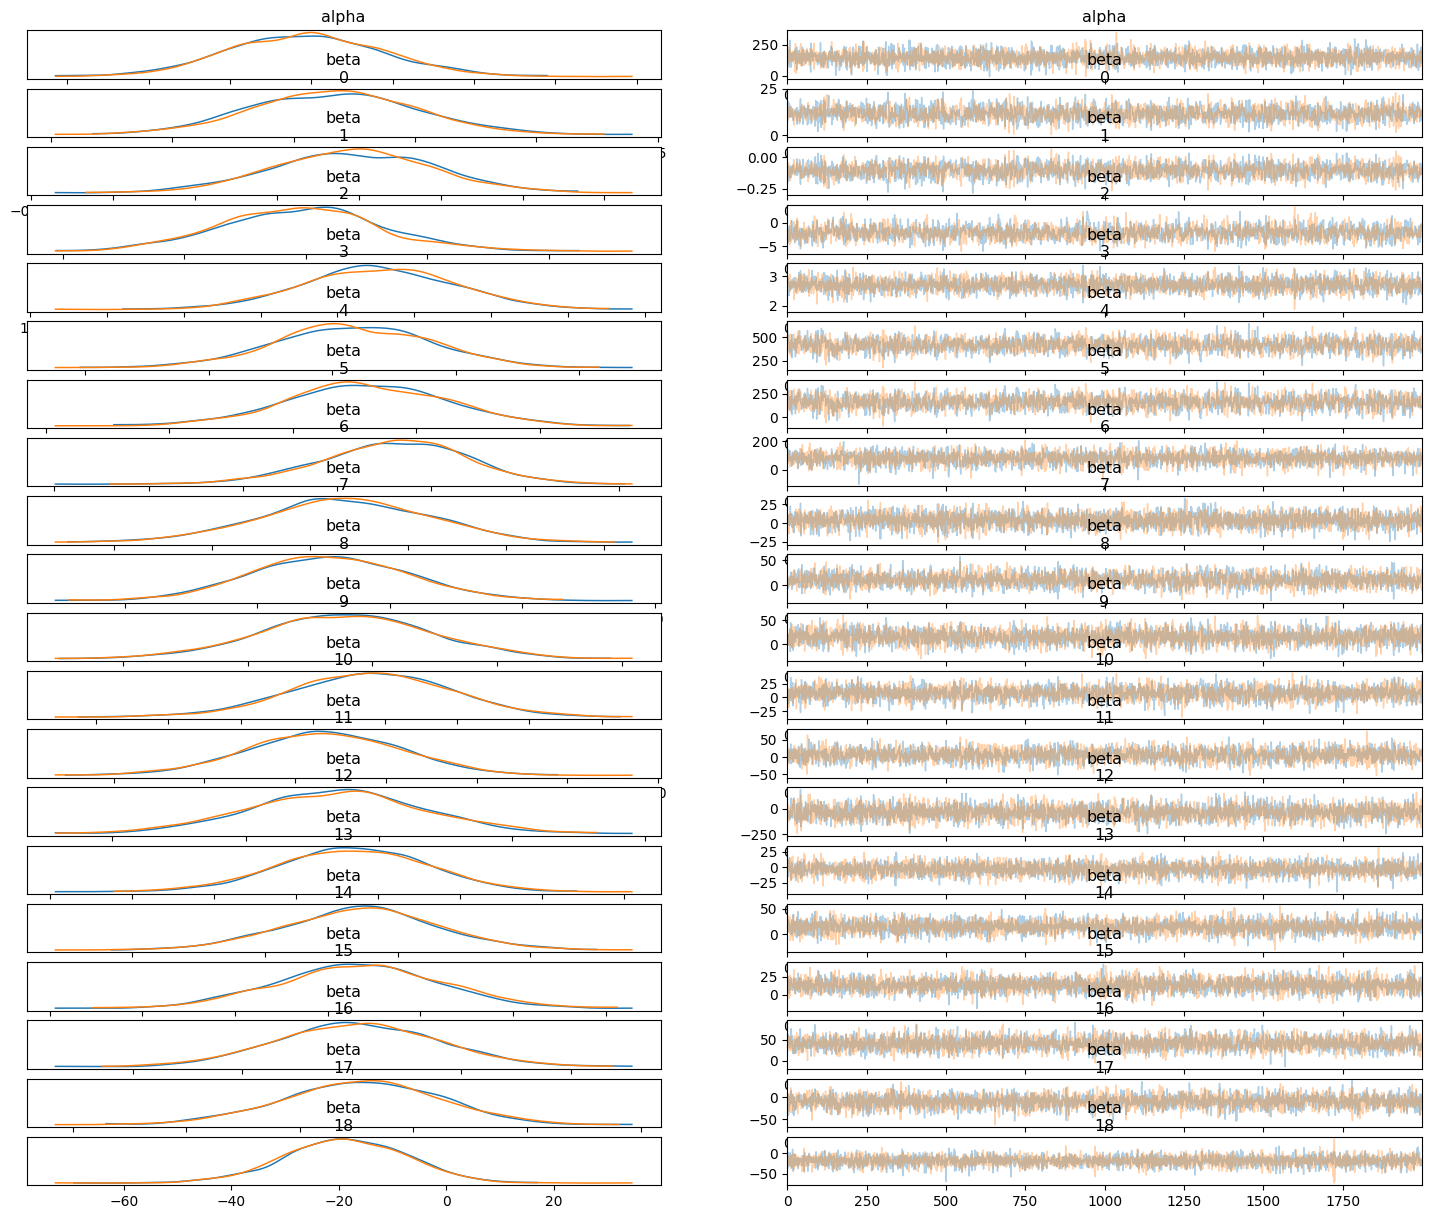

In [72]:
az.plot_trace(run_trace, compact = False, var_names = ['alpha', 'beta'], figsize = (18, 15));

In [73]:
az.summary(run_trace, var_names = ['alpha', 'beta'])

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     146.174  47.503   59.377  235.598      0.686    0.514    4823.0   
beta[0]    11.642   3.446    5.061   18.045      0.072    0.051    2314.0   
beta[1]    -0.104   0.050   -0.197   -0.010      0.001    0.001    2363.0   
beta[2]    -2.071   1.326   -4.596    0.451      0.029    0.021    2061.0   
beta[3]     2.708   0.200    2.337    3.083      0.004    0.002    3262.0   
beta[4]   417.001  63.443  295.630  532.822      1.281    0.906    2456.0   
beta[5]   159.364  65.391   37.728  285.588      1.304    0.922    2515.0   
beta[6]    80.362  38.777    4.516  151.014      0.624    0.441    3903.0   
beta[7]     3.513   8.659  -12.425   19.880      0.123    0.119    4947.0   
beta[8]    10.939  11.811  -10.283   33.705      0.209    0.153    3216.0   
beta[9]    15.648  13.766   -9.801   42.379      0.219    0.172    3960.0   
beta[10]    8.009  11.117  -13.012   28.363      0.184    0.145    3645.0   
beta[11]    6.363  16.944  -23.953   39.173      0.288    0.233    3468.0   
beta[12]  -32.038  65.078 -160.448   86.055      0.983    0.857    4377.0   
beta[13]   -3.075   9.052  -19.631   14.342      0.127    0.131    5129.0   
beta[14]   14.495  11.551   -6.460   36.974      0.152    0.126    5828.0   
beta[15]   13.300   8.747   -3.650   28.844      0.131    0.107    4435.0   
beta[16]   41.152  14.463   14.038   67.987      0.231    0.167    3952.0   
beta[17]   -9.271  13.846  -35.974   16.015      0.227    0.187    3743.0   
beta[18]  -18.796  11.349  -40.653    1.820      0.150    0.126    5670.0   
beta[19]   -9.415  54.828 -108.177   96.854      0.943    0.903    3442.0   
beta[20]   55.486  14.798   27.615   82.344      0.272    0.192    2969.0   
beta[21]  -50.523   8.915  -68.138  -34.494      0.127    0.092    4947.0   
beta[22]  -28.445  19.879  -66.746    7.637      0.298    0.234    4420.0   
beta[23]   20.636  11.069    0.819   42.187      0.198    0.142    3113.0   
beta[24]    2.806   8.266  -13.588   17.210      0.132    0.111    3950.0   
beta[25]   -0.495  17.113  -34.134   30.429      0.329    0.240    2705.0   
beta[26]   26.928  16.189   -3.551   57.107      0.310    0.225    2735.0   
beta[27]   -0.523  11.808  -21.676   22.275      0.181    0.181    4260.0   
beta[28]   -3.542  11.689  -27.554   16.504      0.193    0.161    3688.0   
beta[29]   34.120   8.557   18.359   50.330      0.124    0.093    4738.0   
beta[30]  -34.969  12.273  -57.857  -12.451      0.225    0.163    2987.0   
beta[31]  -26.740  47.345 -118.824   59.874      0.706    0.686    4593.0   
beta[32]  -22.109  13.483  -47.966    2.281      0.224    0.167    3647.0   
beta[33]   -0.966  13.221  -25.657   24.298      0.270    0.197    2388.0   
beta[34]  -26.791  14.029  -52.065   -0.335      0.313    0.221    2022.0   
beta[35]  -31.883   9.885  -50.538  -13.627      0.130    0.099    5714.0   
beta[36]    5.003   8.298   -9.329   21.520      0.126    0.109    4338.0   
beta[37]  -29.598  12.662  -53.741   -5.949      0.202    0.145    3937.0   
beta[38]   23.134  11.569    3.046   46.767      0.265    0.187    1902.0   
beta[39]  127.963  41.279   48.401  206.143      1.296    0.917    1016.0   
beta[40]   80.343  41.375   -0.800  155.459      1.303    0.922    1010.0   
beta[41]   86.196  41.809   10.891  168.448      1.276    0.903    1073.0   
beta[42]  132.582  41.808   48.401  205.213      1.309    0.926    1024.0   
beta[43]   58.914  82.511  -94.846  210.737      1.180    0.957    5096.0   
beta[44]  100.435  42.509   13.570  176.222      1.298    0.918    1074.0   

          ess_tail  r_hat  
alpha       2932.0    1.0  
beta[0]     2439.0    1.0  
beta[1]     2587.0    1.0  
beta[2]     2163.0    1.0  
beta[3]     2873.0    1.0  
beta[4]     2740.0    1.0  
beta[5]     2742.0    1.0  
beta[6]     2738.0    1.0  
beta[7]     3071.0    1.0  
beta[8]     3321.0    1.0  
beta[9]     3006.0    1.0  
beta[10]    2887.0    1.0  
beta[11]    3052.0    1.0  
b

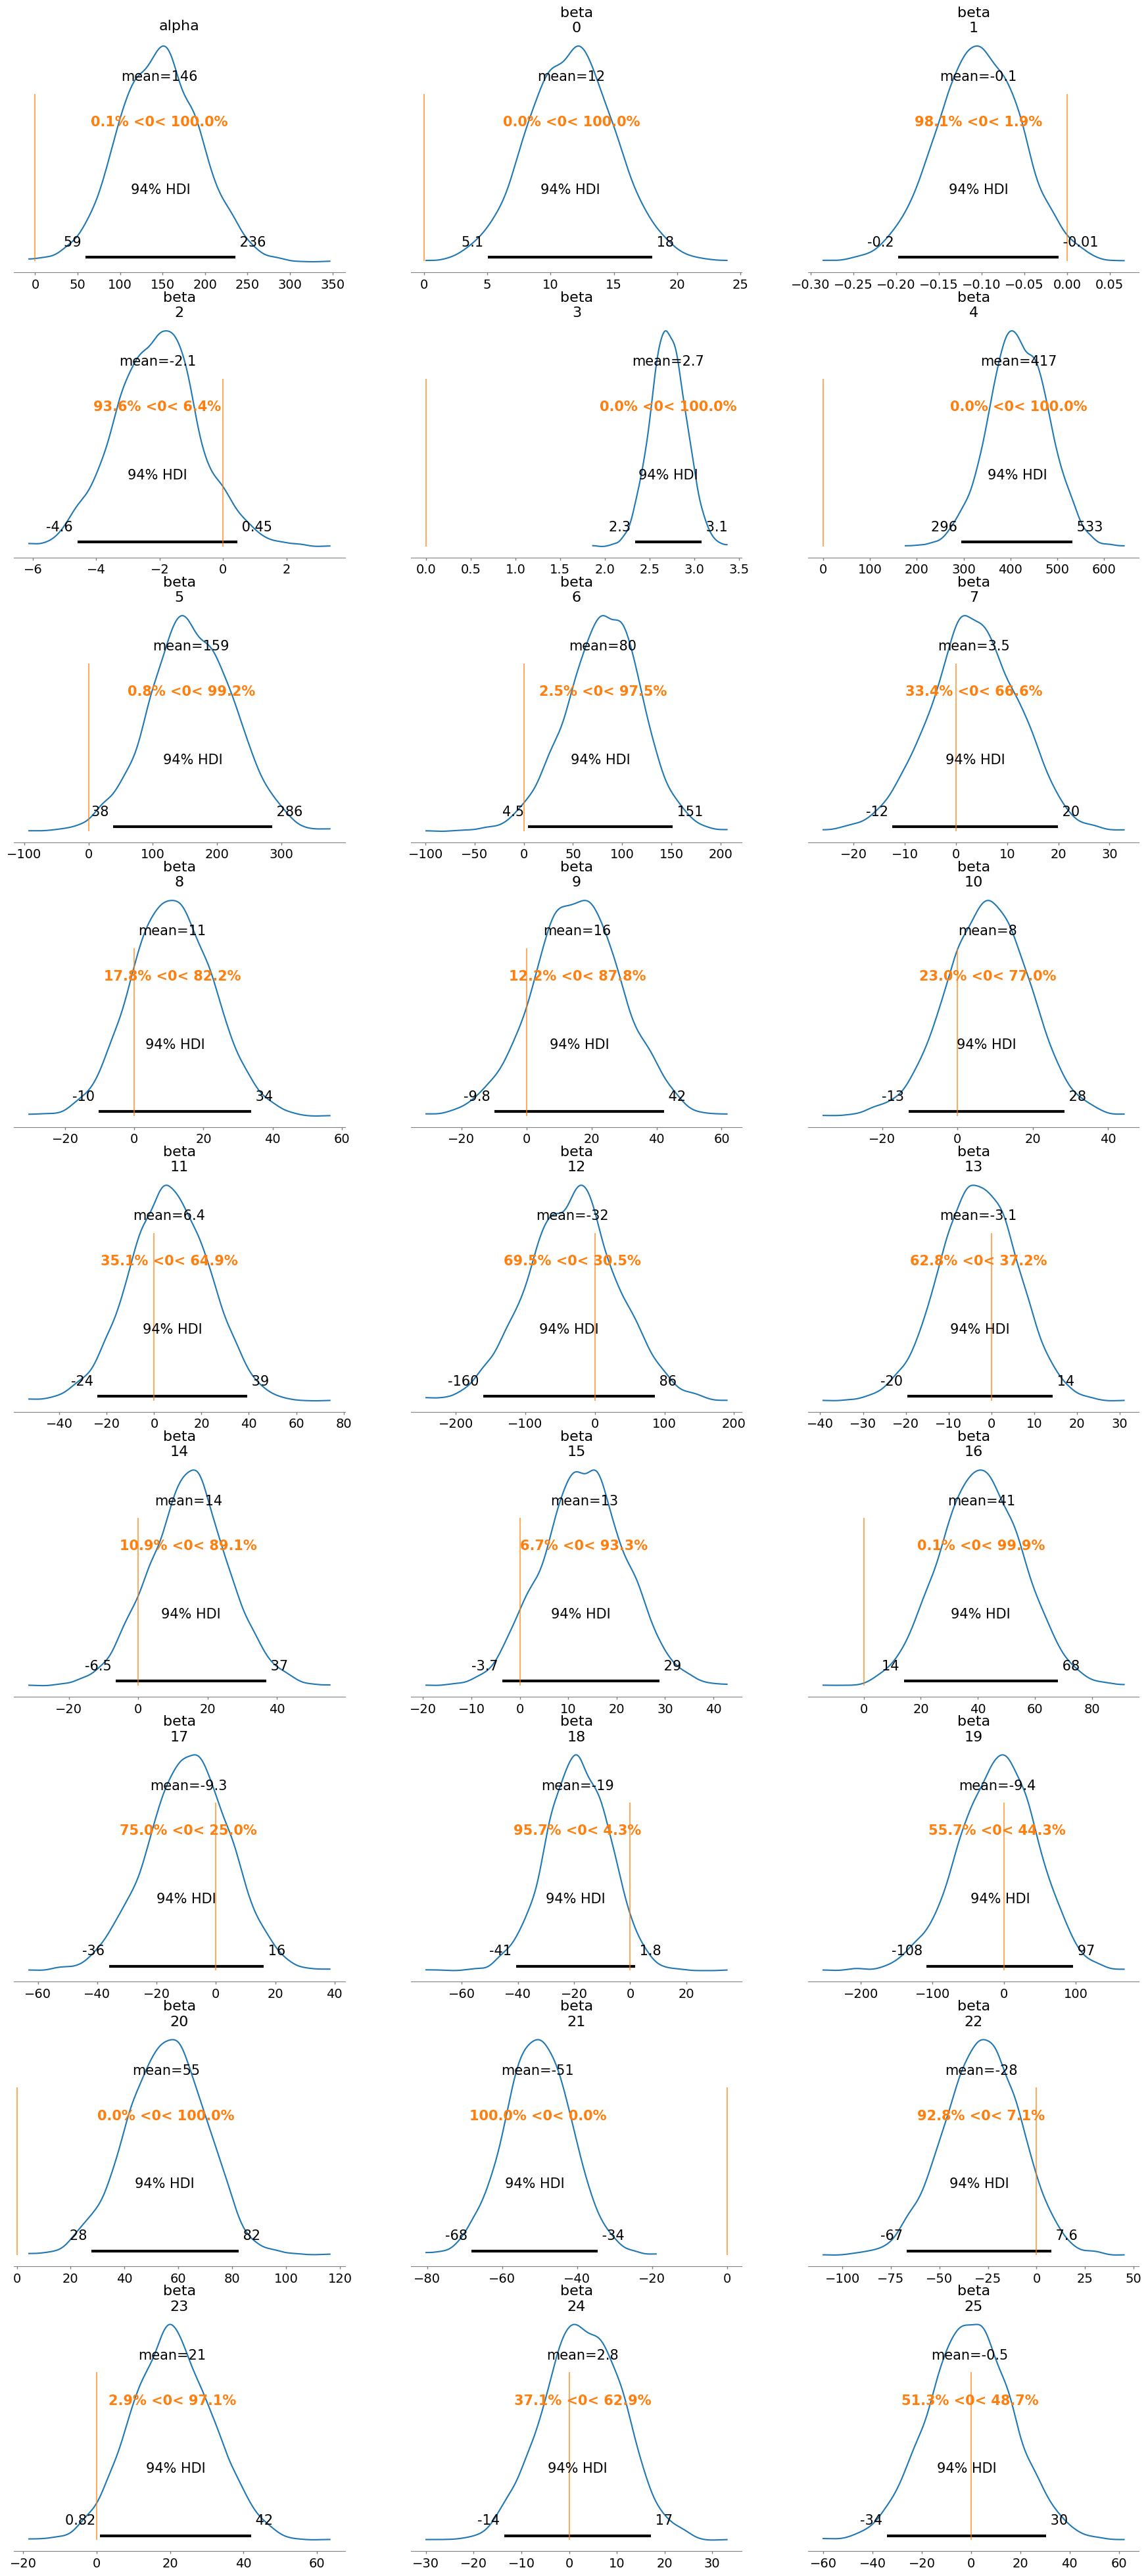

In [74]:
az.plot_posterior(
    run_trace,
    var_names=['alpha', 'beta'],
    ref_val=0,
    coords={'beta_dim_0': slice(0, 25)}
);

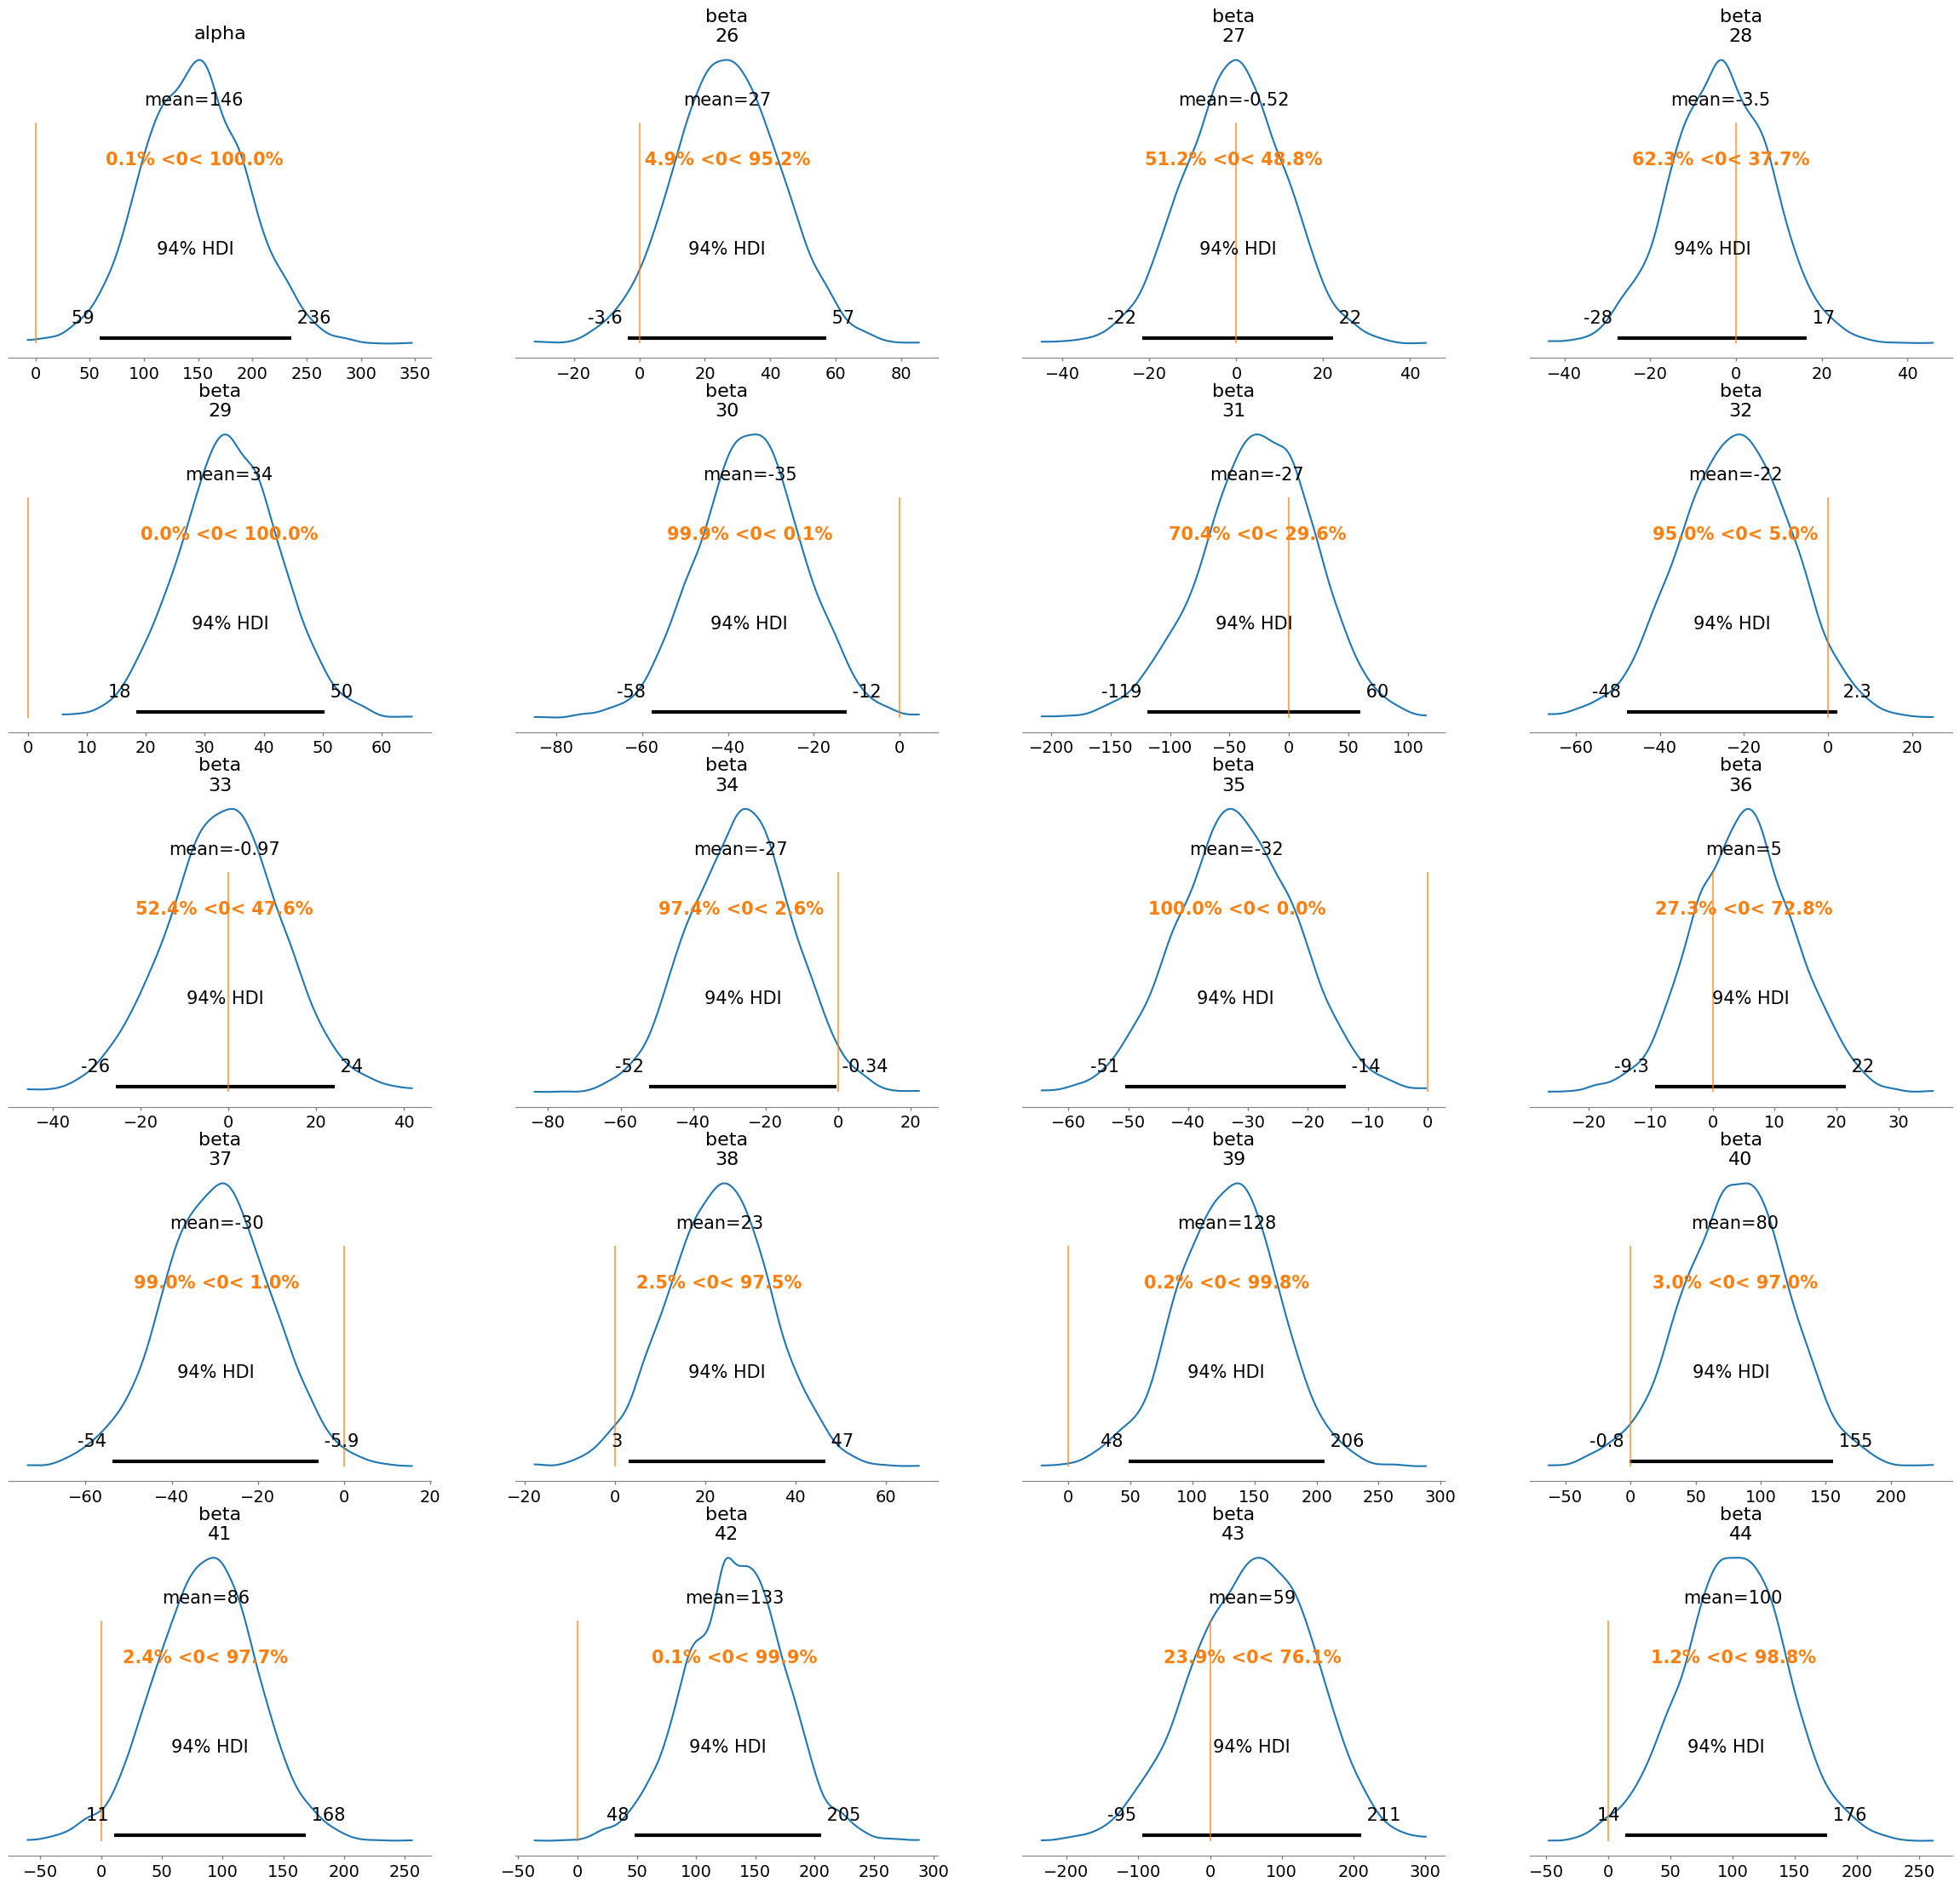

In [75]:
az.plot_posterior(
    run_trace,
    var_names=['alpha', 'beta'],
    ref_val=0,
    coords={'beta_dim_0': slice(26, 45)}
);

<Axes: title={'center': 'y / y'}>

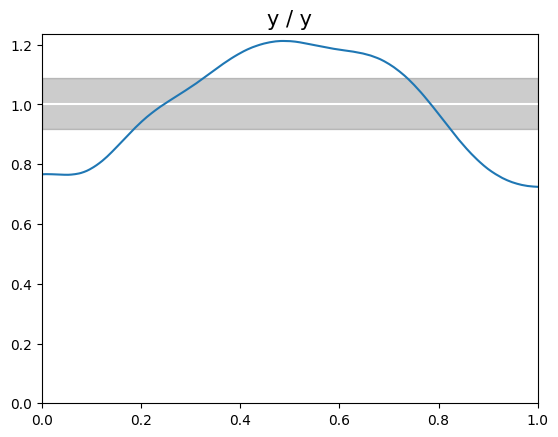

In [76]:
run_pp = pm.sample_posterior_predictive(
    run_trace,
    model = run_model
)

az.plot_bpv(run_pp)

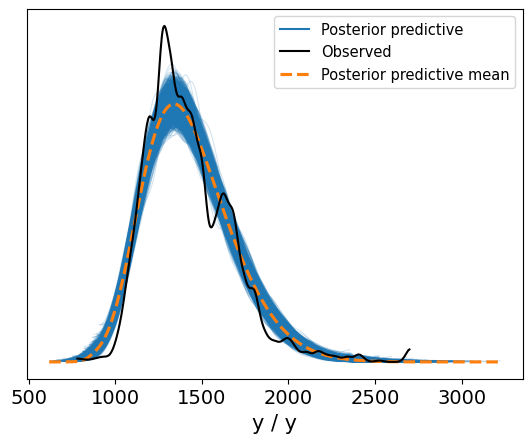

In [77]:
az.plot_ppc(run_pp);

In [78]:
with pm.Model() as run_model2:
    # Priors for coefficients
    beta = pm.Normal('beta', mu = 0, sigma = 100, shape = k)
    sigma = pm.HalfNormal('sigma', sigma = 100)

    # Intercept
    alpha = pm.Normal('alpha', mu = 0, sigma = 50)

    # Linear regression model
    mu = pm.Deterministic('mu', alpha + pm.math.dot(run_x, beta))

    # Likelihood
    y = pm.SkewNormal('y', alpha = 4, mu = mu, sigma = sigma, observed = run_y)

In [79]:
with run_model2:
    run_trace2 = pm.sample(2000, tune = 1000, random_seed = 31958)

<Axes: title={'center': 'y / y'}>

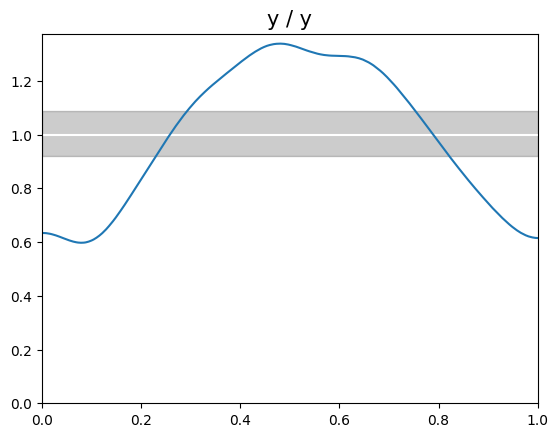

In [80]:
run_pp2 = pm.sample_posterior_predictive(
    run_trace2,
    model = run_model2
)

az.plot_bpv(run_pp2)

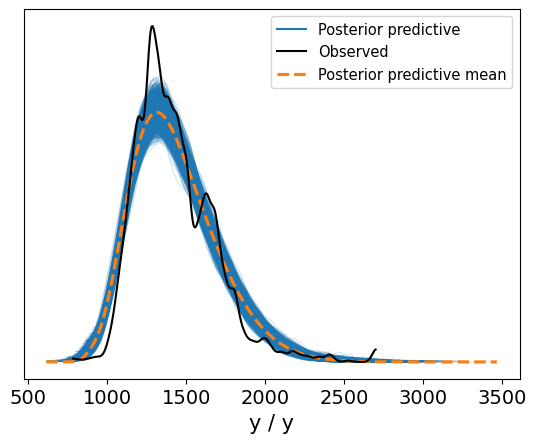

In [81]:
az.plot_ppc(run_pp2);

In [82]:
with pm.Model() as run_model3:
    # Priors for coefficients
    beta = pm.Normal('beta', mu = 0, sigma = 100, shape = k)
    sigma = pm.HalfNormal('sigma', sigma = 100)

    # Intercept
    alpha = pm.Normal('alpha', mu = 0, sigma = 50)

    # Linear regression model
    mu = pm.Deterministic('mu', alpha + pm.math.dot(run_x, beta))

    # Likelihood
    y = pm.SkewNormal('y', alpha = 5, mu = mu, sigma = sigma, observed = run_y)

In [83]:
with run_model3:
    run_trace3 = pm.sample(2000, tune = 1000, random_seed = 31958)

<Axes: title={'center': 'y / y'}>

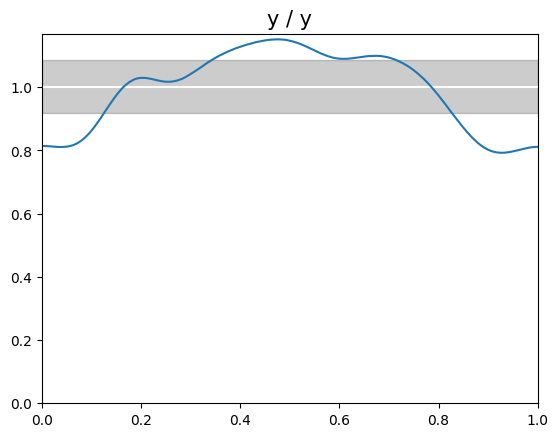

In [84]:
run_pp3 = pm.sample_posterior_predictive(
    run_trace3,
    model = run_model3
)

az.plot_bpv(run_pp3)

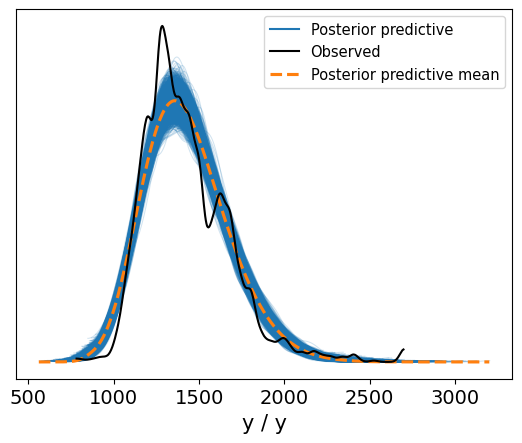

In [86]:
az.plot_ppc(run_pp3);